In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib
import numba
from scipy.io import wavfile
from IPython.display import Audio



In [28]:
Nx = 101
Nt = 2000000
scaleLength = 0.65
neckLength = 0.43
numberOfFrets = 19
samplerate = 44000
downRateFactor = 5
amplitude = 0.002

dt = 5e-6
l=5e-5
gamma=5e-5

def noteToFrequency(note):
    if note == 'E':
        return 82#80.5
    elif note == 'A':
        return 108#108
    elif note == 'D':
        return 146.83#145
    elif note == 'G':
        return 193#193.5
    elif note == 'B':
        return 246#243.5
    elif note == 'e':
        return 331#325

    
def initialCondition(initialLength, totalLength):
    #pluck_position = int(initialLength / totalLength * Nx)
    #ya = np.linspace(0, 0.01, pluck_position)
    #yb = np.linspace(0.01, 0, Nx - pluck_position)
    #return np.concatenate([ya, yb])

    x = np.linspace(0, totalLength, Nx)
    sigma = 0.1  
    y = np.exp(-(x - initialLength)**2 / (2 * sigma**2))
    return amplitude* y / np.max(y)  


def notePosition(noteNumber):
    n = numberOfFrets - noteNumber
    noteLength = scaleLength - neckLength
    for i in range(n):
        noteLength += 1/100 + i/1000 + 2/1000
        if i/10 >= 1.5:
            noteLength += 1/1000
    return noteLength - 1/1000

@numba.jit("f8[:,:](f8[:,:], i8, i8, f8, f8, f8, f8, f8)", nopython=True, nogil=True)
def computeSolution(d, times, length, dt, dx, l, gamma, c):
    for t in range(1, times-1):
        for i in range(2, length-2):
            outer_fact = (1/(c**2 * dt**2) + gamma/(2*dt))**(-1)
            p1 = 1/dx**2 * (d[t][i-1] - 2*d[t][i] + d[t][i+1])
            p2 = 1/(c**2 * dt**2) * (d[t-1][i] - 2*d[t][i])
            p3 = gamma/(2*dt) * d[t-1][i]
            p4 = l**2 / dx**4 * (d[t][i+2] - 4*d[t][i+1] + 6*d[t][i] - 4*d[t][i-1] + d[t][i-2])
            d[t+1][i] = outer_fact * (p1 - p2 + p3 - p4)
    return d

def fourierAnalysis(n, sol):
    sin_arr = np.sin(n*np.pi*np.linspace(0,1,Nx))
    return np.multiply(sol, sin_arr).sum(axis=1)

def createNote(noteNumber, string):
    c = 2*scaleLength*noteToFrequency(string)
    noteLength = notePosition(noteNumber)
    dx = noteLength/(Nx-1)
    y0 = initialCondition(scaleLength/4, noteLength)

    sol = np.zeros((Nt, Nx))
    sol[0] = y0
    sol[1] = y0
    sol = computeSolution(sol, Nt, Nx, dt, dx, l, gamma, c)
    
    hms = [fourierAnalysis(n, sol) for n in range(10)]
    return sum(hms)[::downRateFactor], sol

def playNote(note, name='note'):
    tot = note.astype(np.float32)
    wavfile.write(f'{name}.wav',int(1/(dt*downRateFactor)),tot)
    return Audio(f'{name}.wav')

def thicknessAnimation(noteName):
    if 'E' in noteName:
        return 3 - 1/6
    elif 'A' in noteName:
        return 3 - 4/6
    elif 'D' in noteName:
        return 3 - 6/6
    elif 'G' in noteName:
        return 3 - 8/6
    elif 'B' in noteName:
        return 3 - 10/6
    elif 'e' in noteName:
        return 3 - 12/6

def makeAnimation(solution, name):
    fps = 30
    def animate(i):
        ax.clear()
        if i < 10:
            color = 'yellow'
        else:
            color = 'white'
        ax.plot(solution[int(i/(dt*fps))], color=color, linewidth=thicknessAnimation(name))
        ax.set_ylim(-0.003, 0.003)
        ax.axis('off')
        ax.set_facecolor('black')
        
    fig, ax = plt.subplots(1,1,figsize=((30,2)))
    ax.set_ylim(-0.01, 0.01)
    ani = animation.FuncAnimation(fig, animate, frames=int(Nt*dt*fps), interval=1000*dt)
    ani.save(f'{name}.mp4',writer='ffmpeg',fps=fps,savefig_kwargs={'facecolor':'black'})

def createNoteAndMakeAnimation(noteNumber, string):
    note, solution = createNote(noteNumber, string)
    makeAnimation(solution, f'{string}{noteNumber}')
    playNote(note, f'{string}{noteNumber}')

def createChord(notes):
    chord = np.zeros(int(Nt/downRateFactor))
    for n in notes:
        note, _ = createNote(*n)
        chord += note
    return chord
    
def createChordAndmakeChordAnimation(noteNumbers, stringNames, name='test'):
    strings = []
    chord = np.zeros(int(Nt/downRateFactor))
    for i in range(6):
        if stringNames[i] == 'N':
            string = np.zeros((Nt, Nx))
        else: 
            string = np.zeros((Nt, int(Nx * scaleLength / notePosition(noteNumbers[i]))))
            note, solution = createNote(noteNumbers[i], stringNames[i])
            string[:, :Nx] = solution
            chord += note
        string[:, :] += i * 2 * amplitude
        strings.append(string)
    playNote(chord, name)

    fps = 30
    def animate(i):
        ax.clear()
        for n, string in enumerate(strings):
            stringFrame = string[int(i/(dt*fps))]
            ax.plot(notePosition(noteNumbers[n]) / scaleLength * np.arange(len(stringFrame)), stringFrame, color='white')
        ax.set_ylim(-amplitude, 12*amplitude)
        ax.axis('off')
        ax.set_facecolor('black')
    fig, ax = plt.subplots(1,1,figsize=((25,12)))
    ax.set_ylim(-amplitude, 12*amplitude)
    ani = animation.FuncAnimation(fig, animate, frames=int(Nt*dt*fps), interval=1000*dt)
    ani.save(f'{name}.mp4',writer='ffmpeg',fps=fps,savefig_kwargs={'facecolor':'black'})

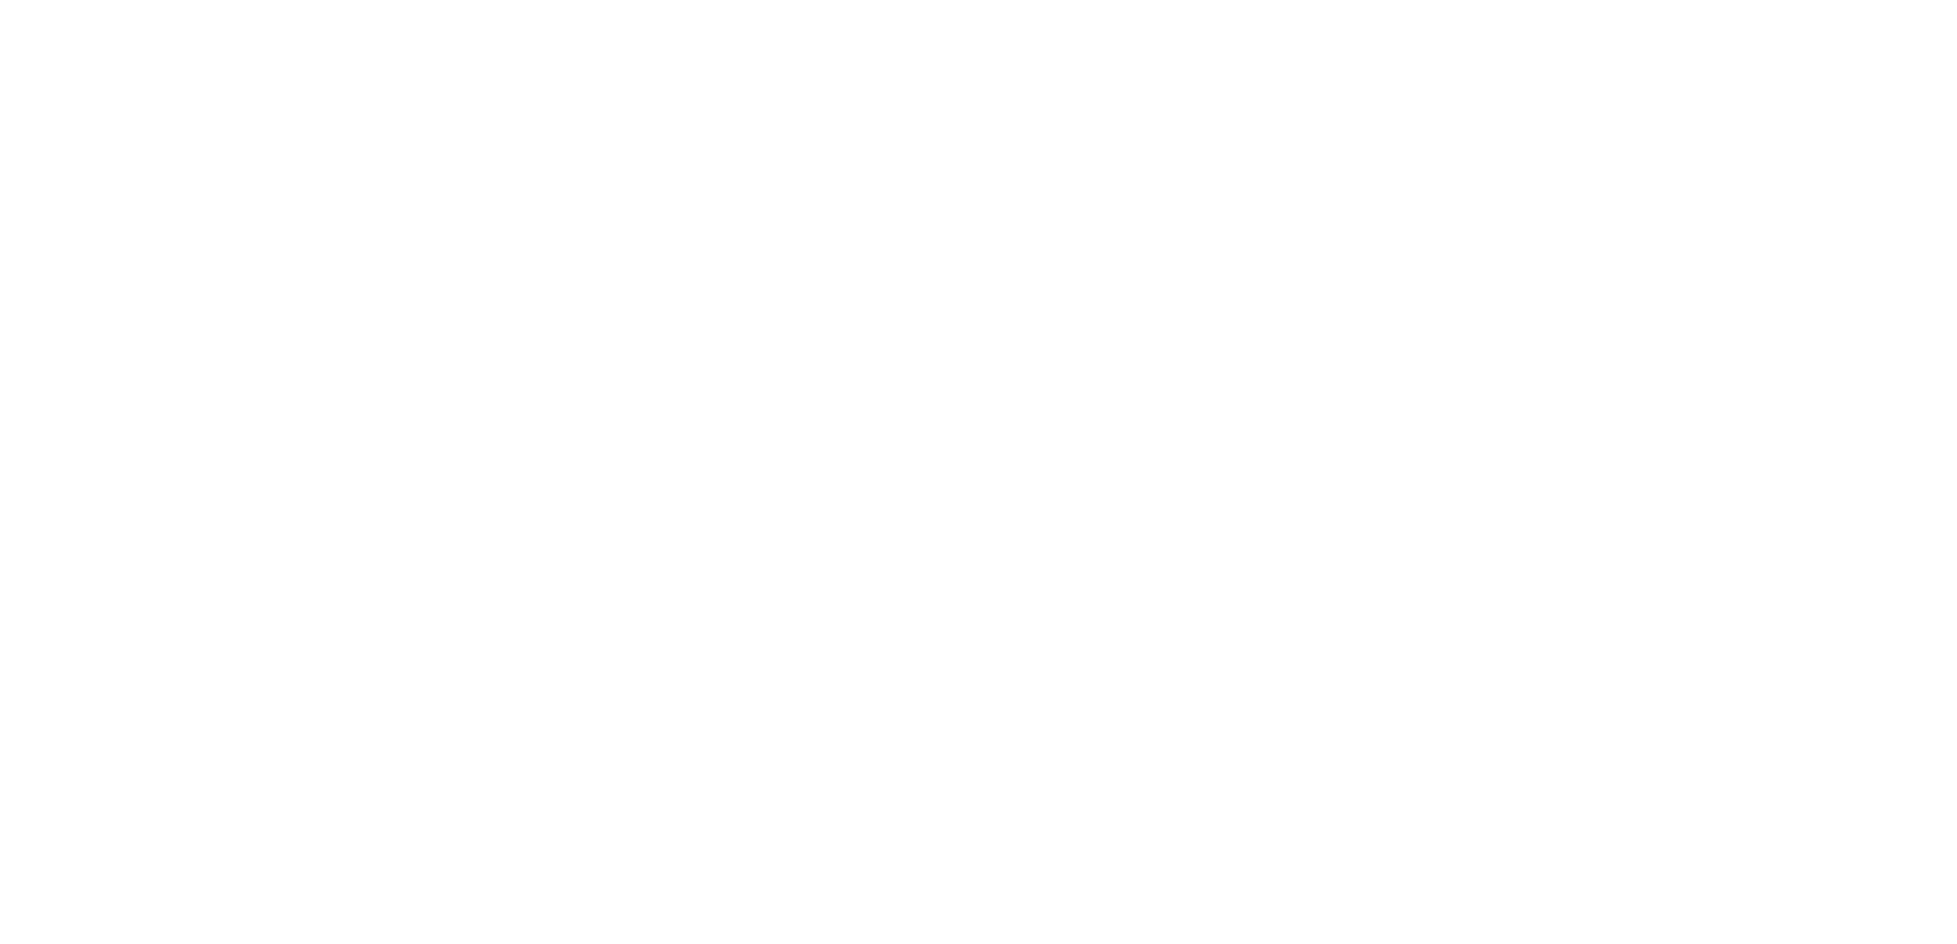

In [25]:
createChordAndmakeChordAnimation([0,0,0,0,0,0],['N','N','N','N','N','N'],'Silence-Long')


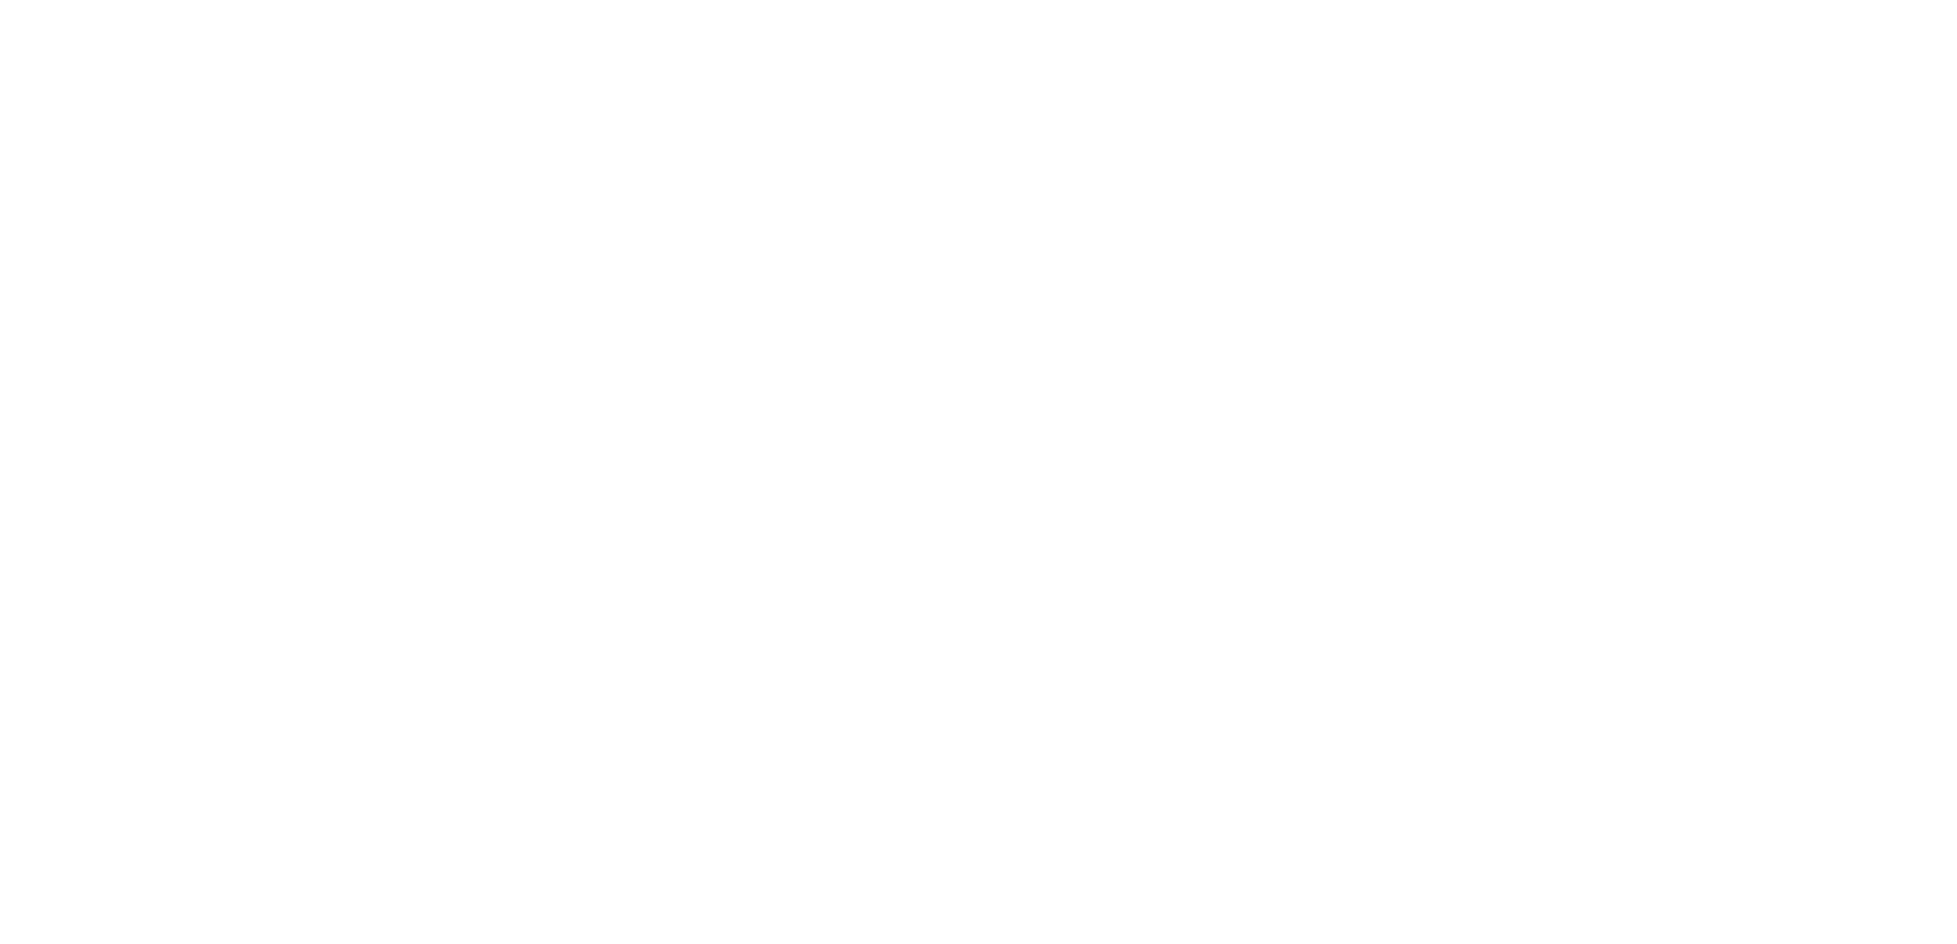

In [29]:
createChordAndmakeChordAnimation([0,0,0,5,5,0],['N','N','N','D','A','N'],'DA55-Long')


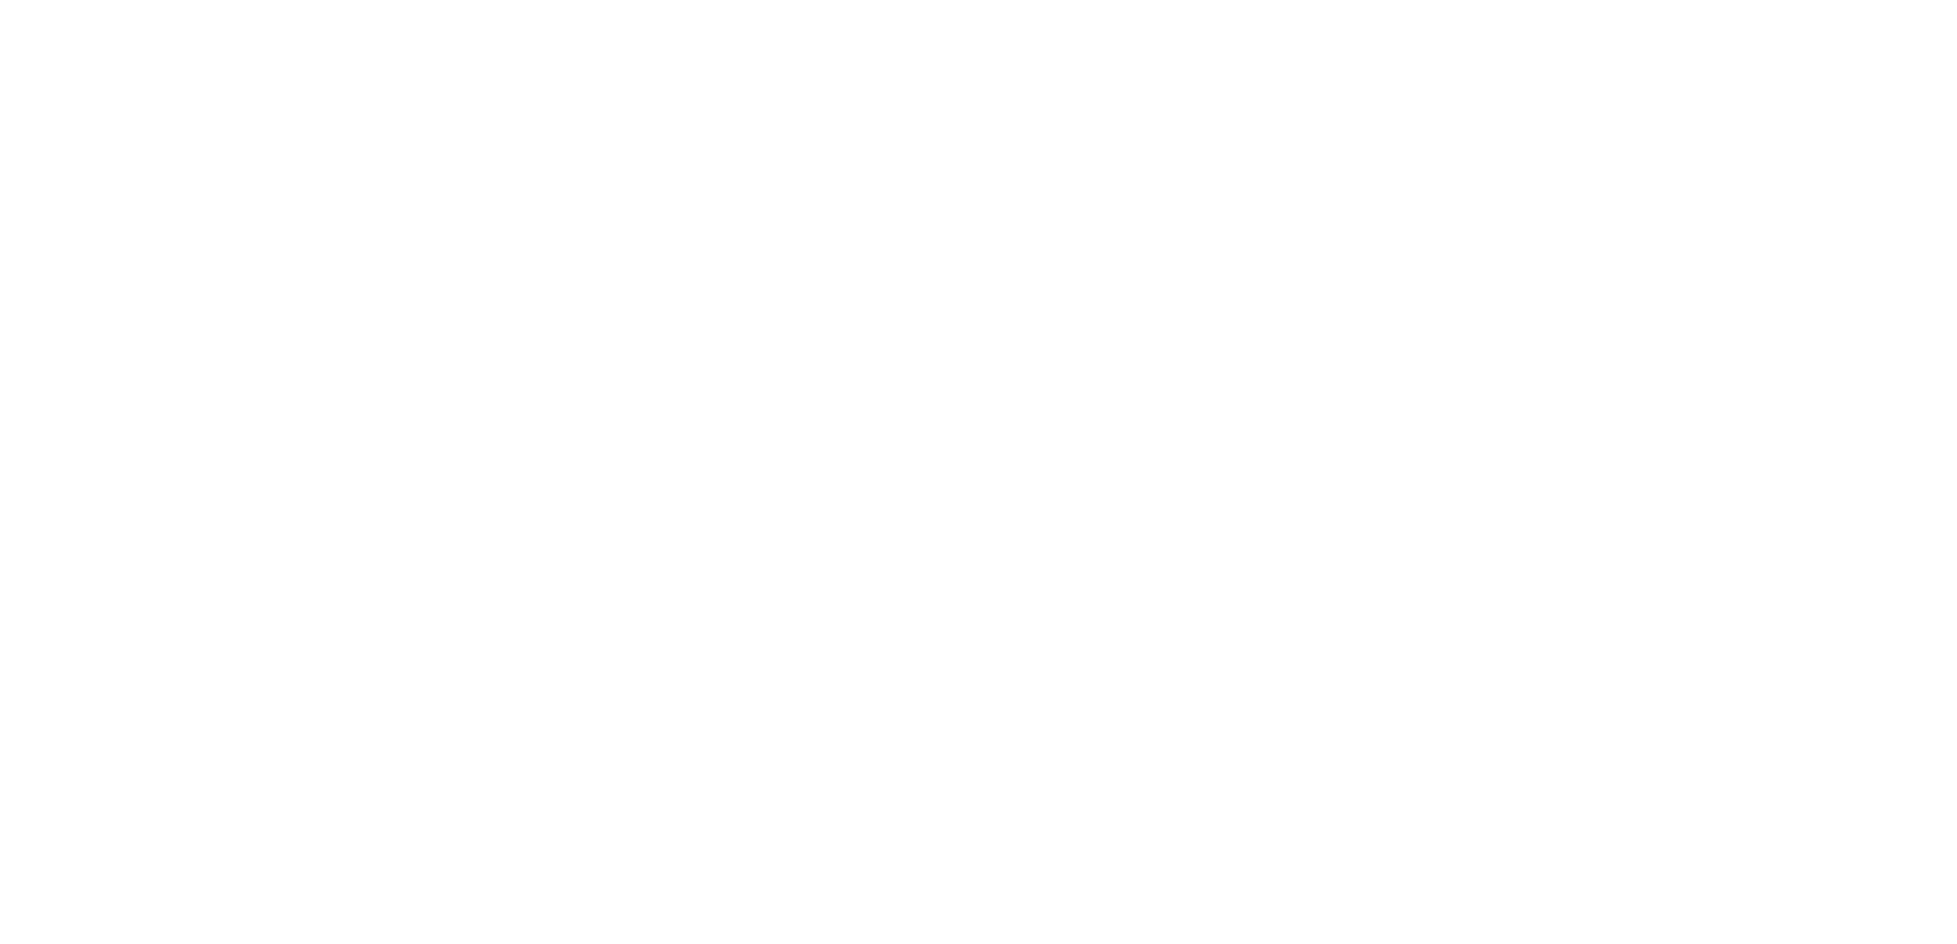

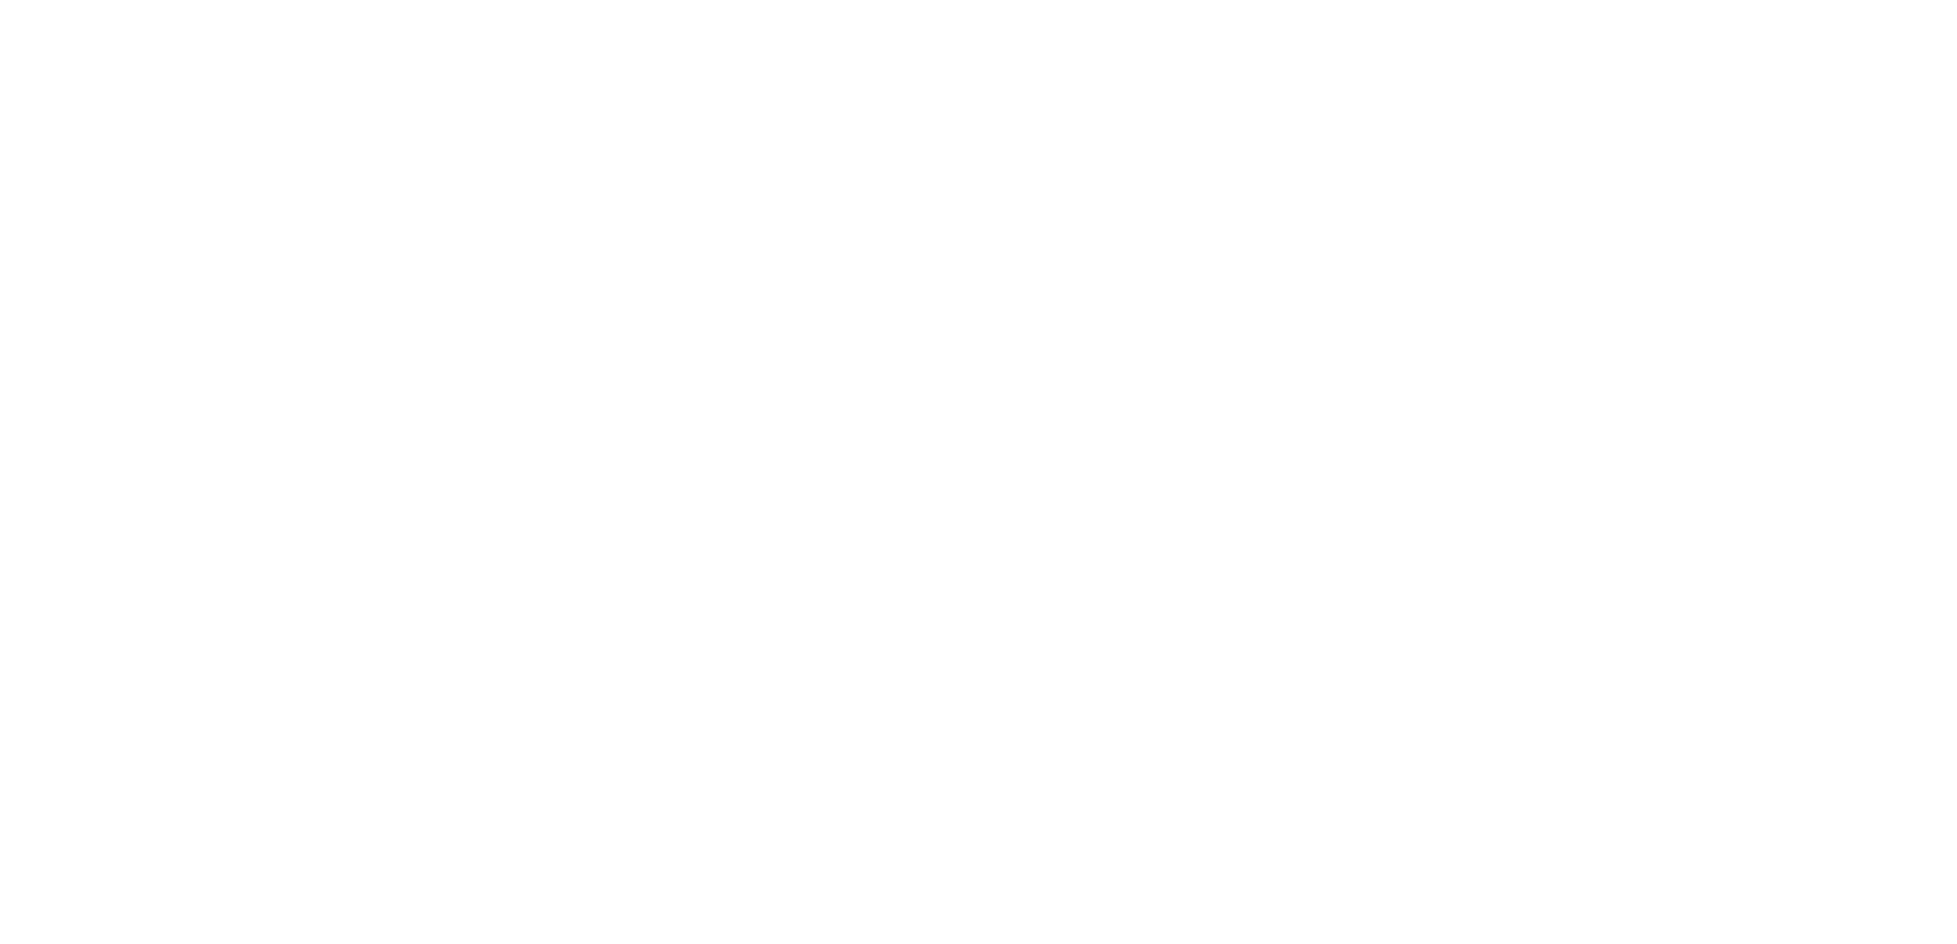

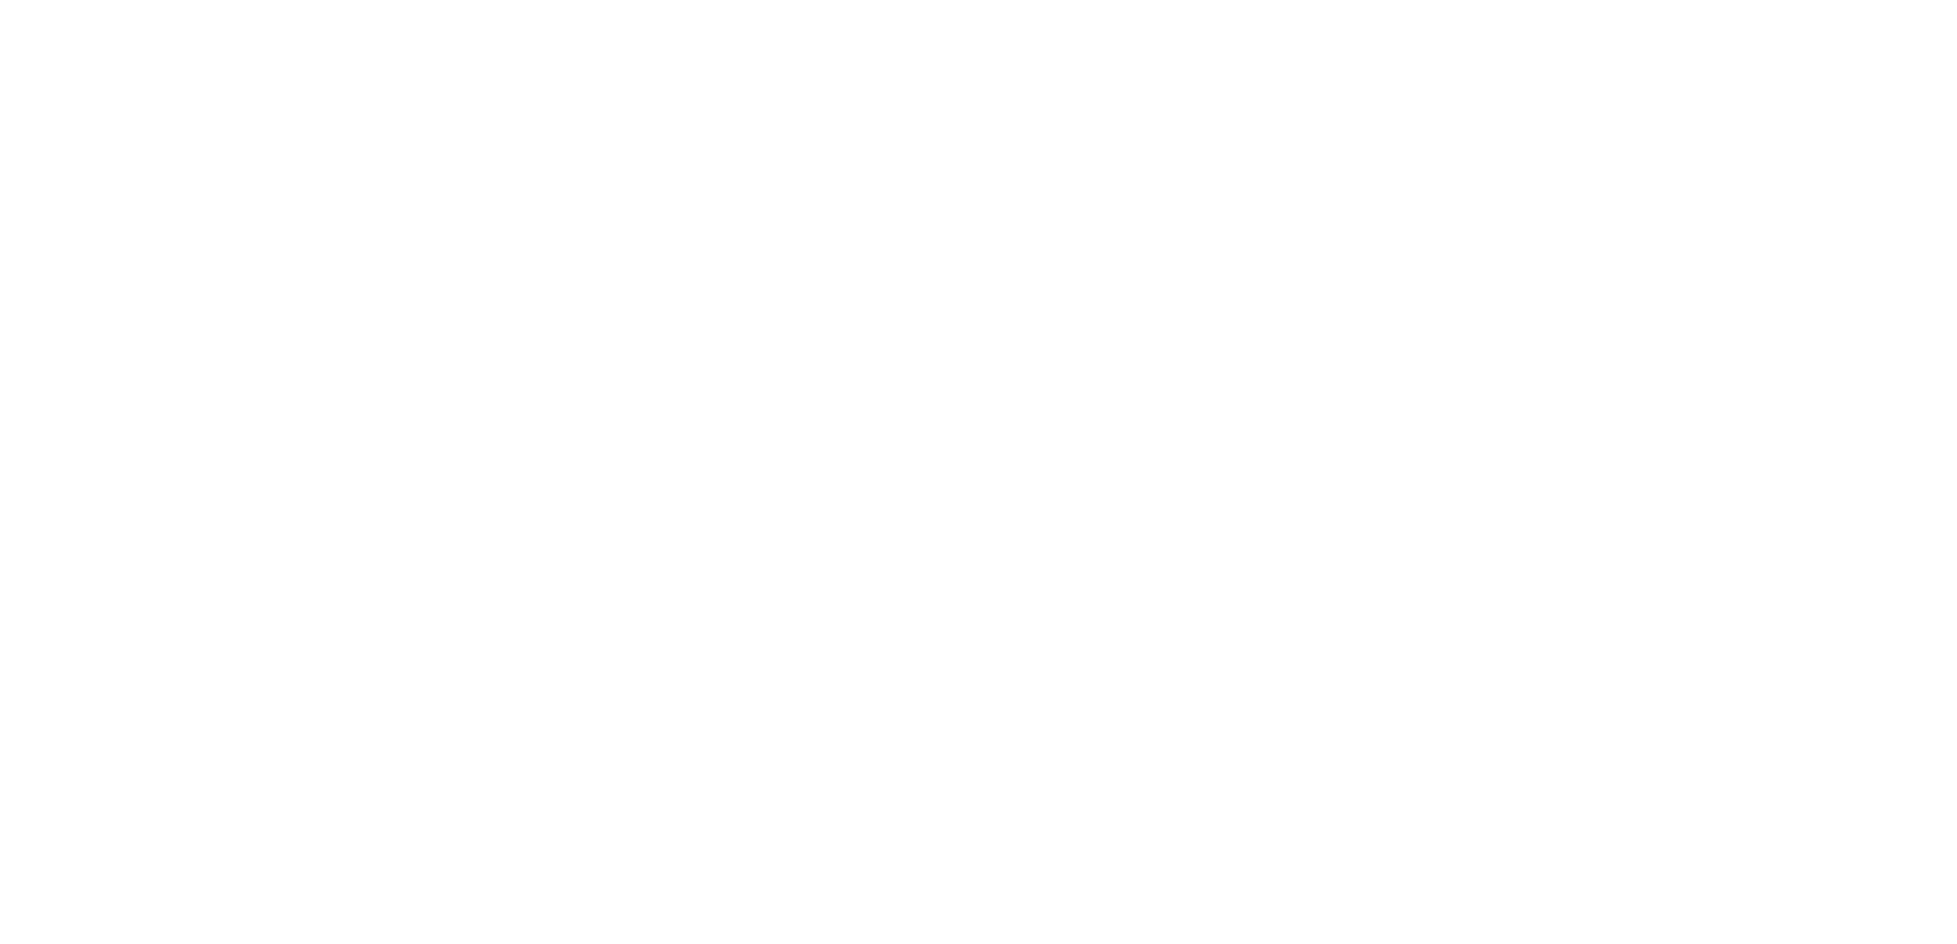

In [12]:
createChordAndmakeChordAnimation([0,0,0,5,5,0],['N','N','N','D','A','N'],'DA55')
createChordAndmakeChordAnimation([0,0,3,3,0,0],['N','N','G','D','N','N'],'GD33')
createChordAndmakeChordAnimation([0,0,5,5,0,0],['N','N','G','D','N','N'],'GD55')



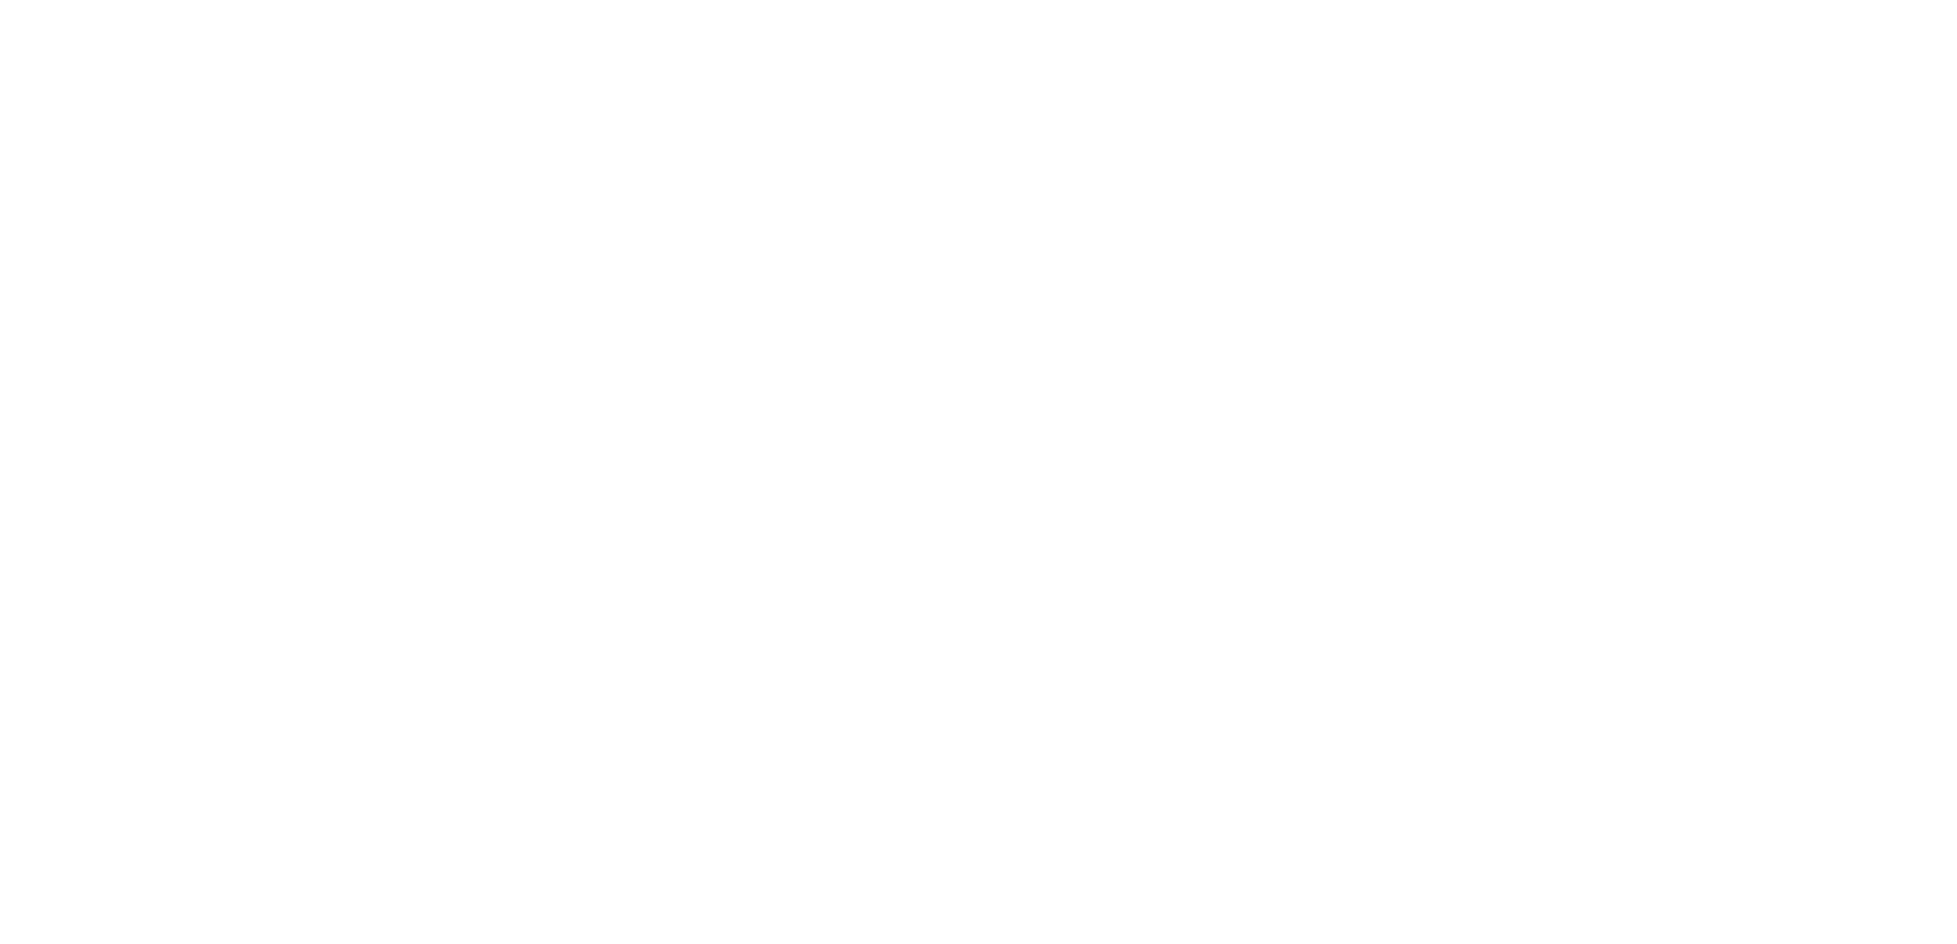

In [13]:
createChordAndmakeChordAnimation([0,0,6,6,0,0],['N','N','G','D','N','N'],'GD66')


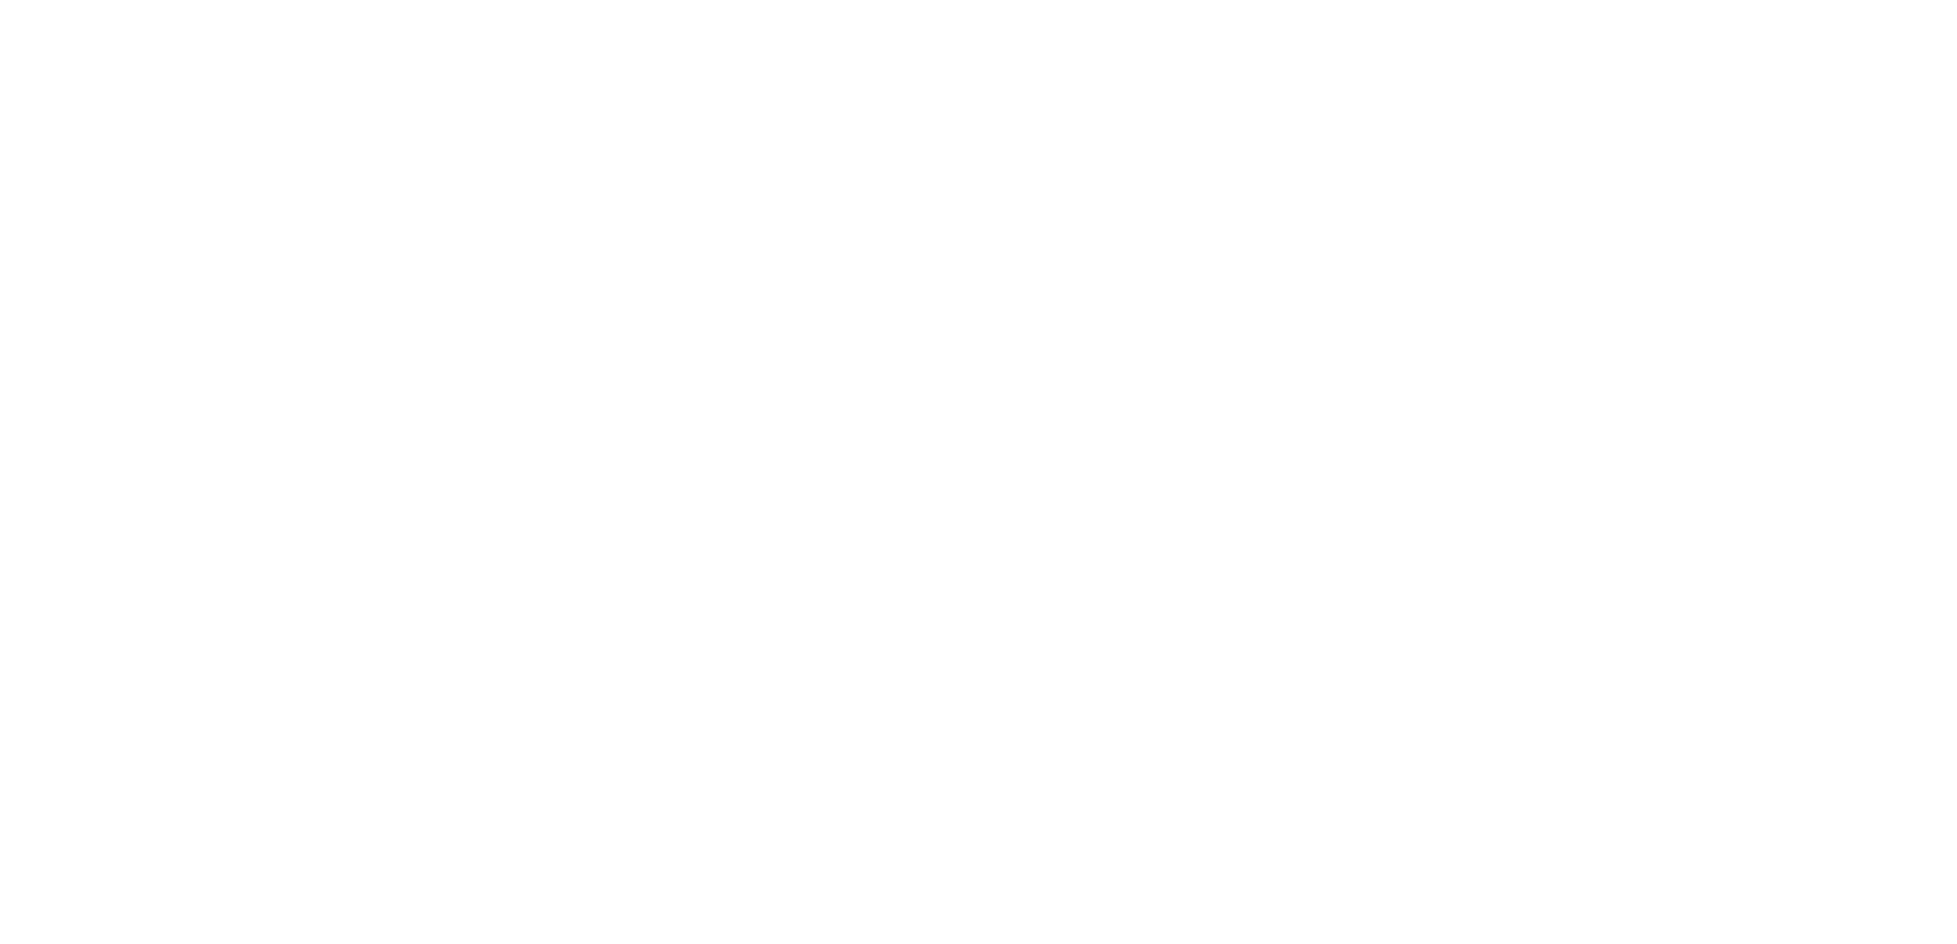

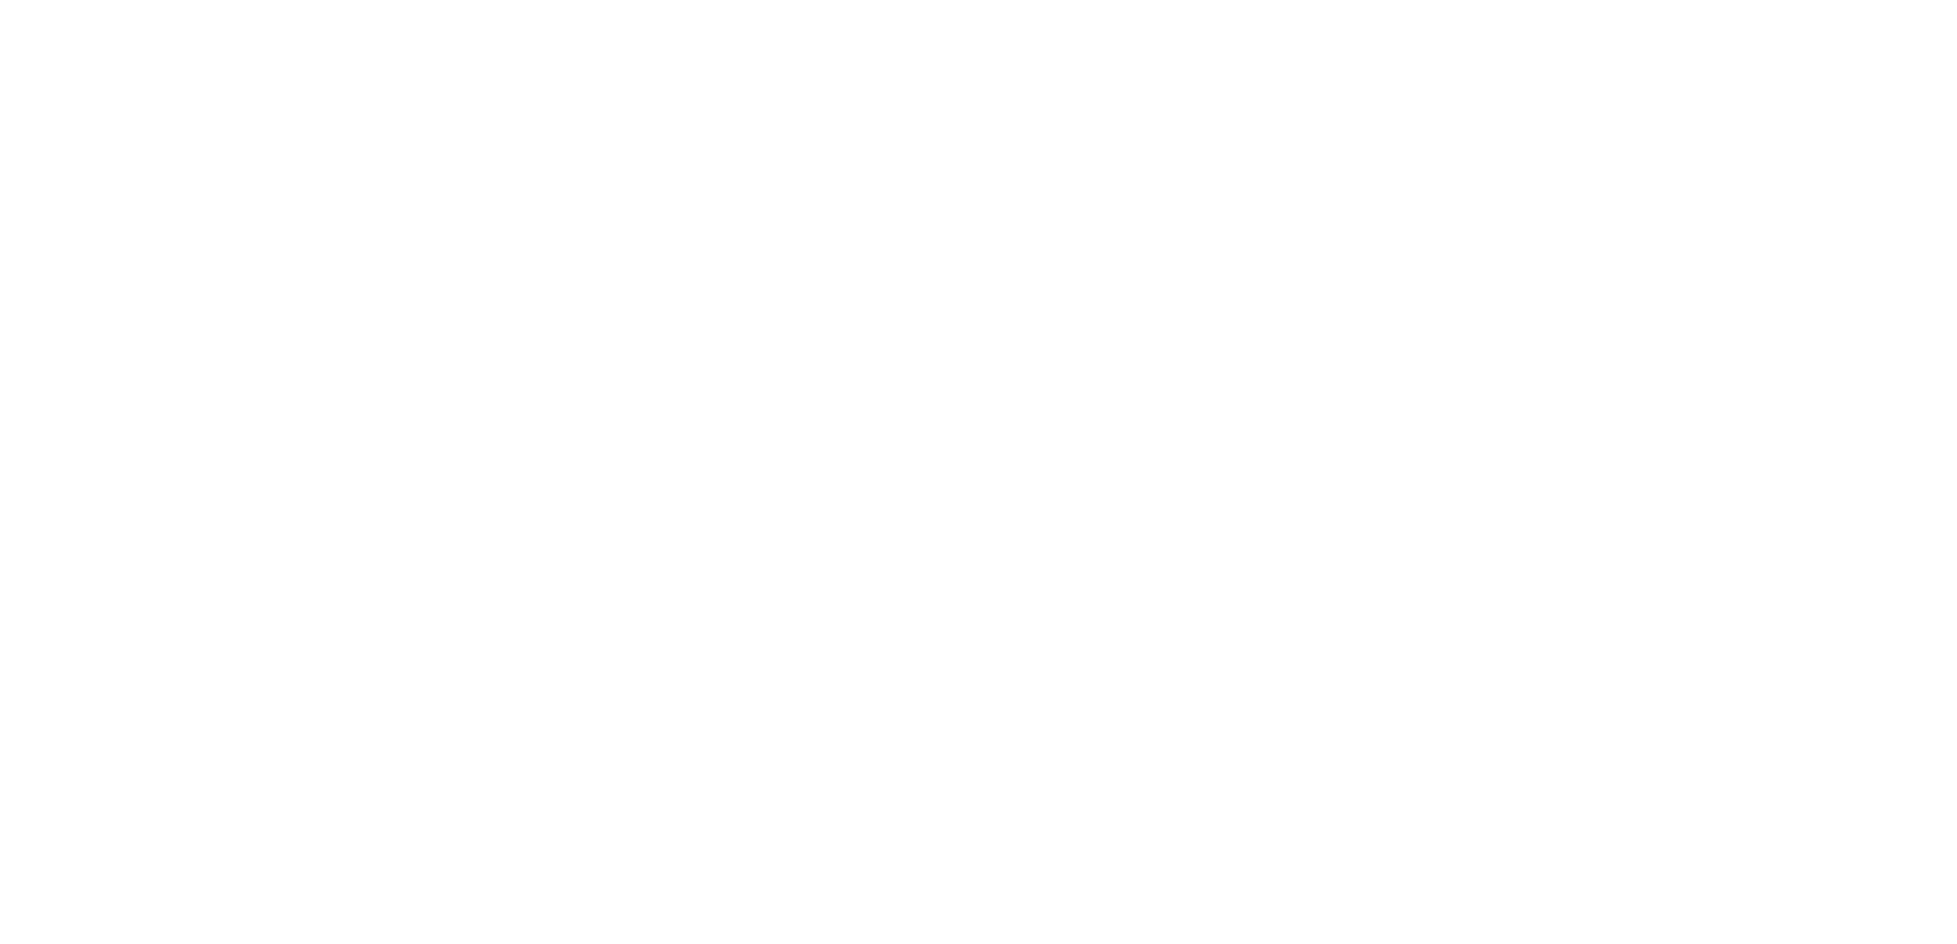

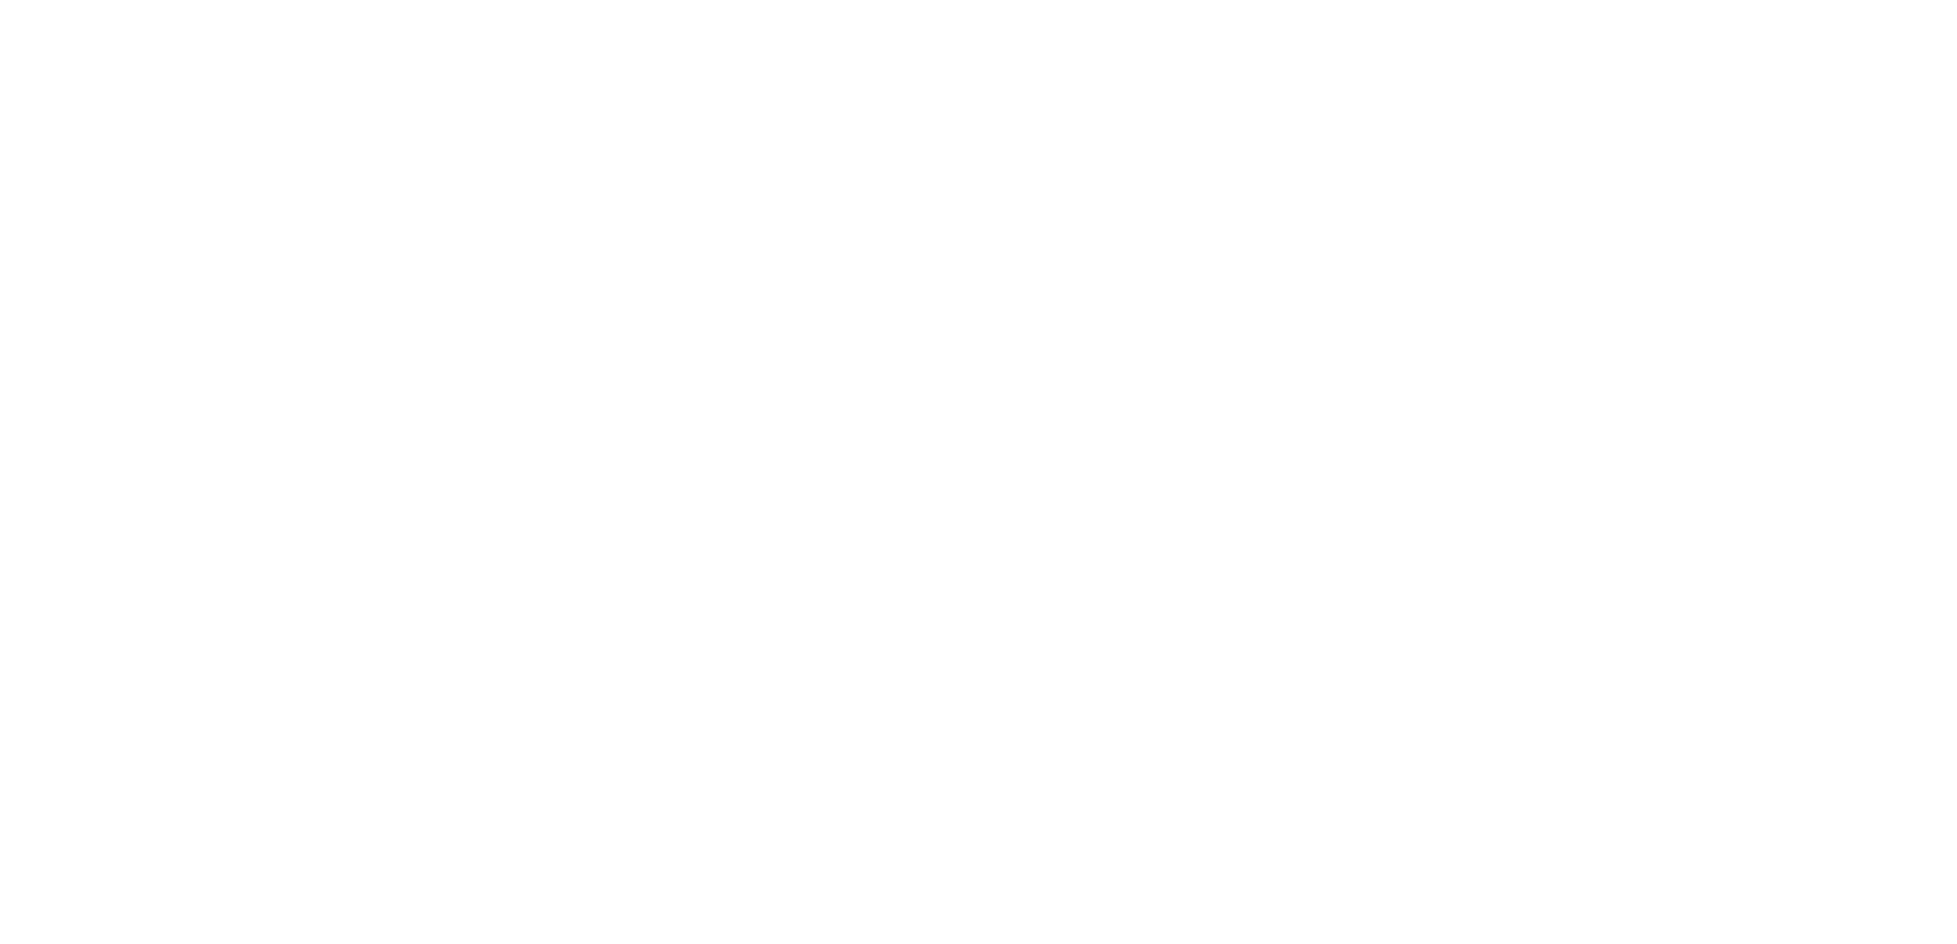

In [15]:
createChordAndmakeChordAnimation([0,0,0,0,0,0],['N','N','N','N','N','E'],'E0')
createChordAndmakeChordAnimation([0,0,0,0,0,1],['N','N','N','N','N','E'],'E1')
createChordAndmakeChordAnimation([0,0,0,0,0,2],['N','N','N','N','N','E'],'E2')



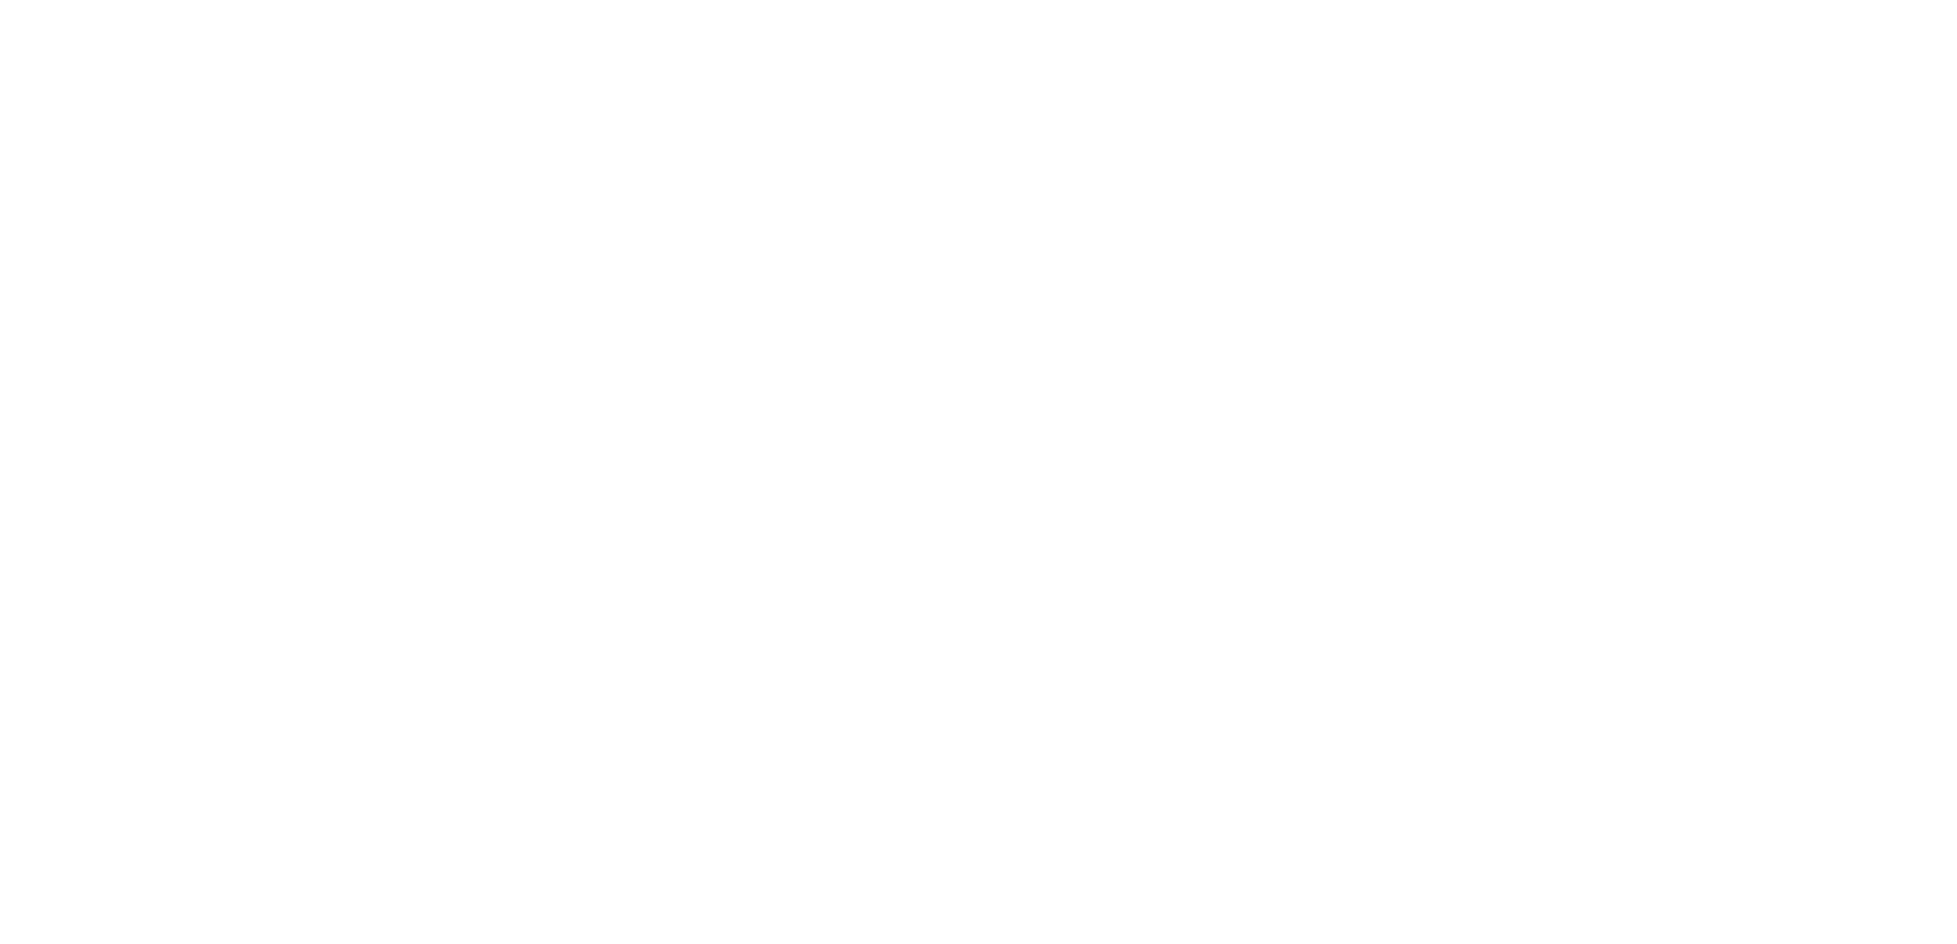

In [16]:
createChordAndmakeChordAnimation([0,0,0,0,0,3],['N','N','N','N','N','E'],'E3')


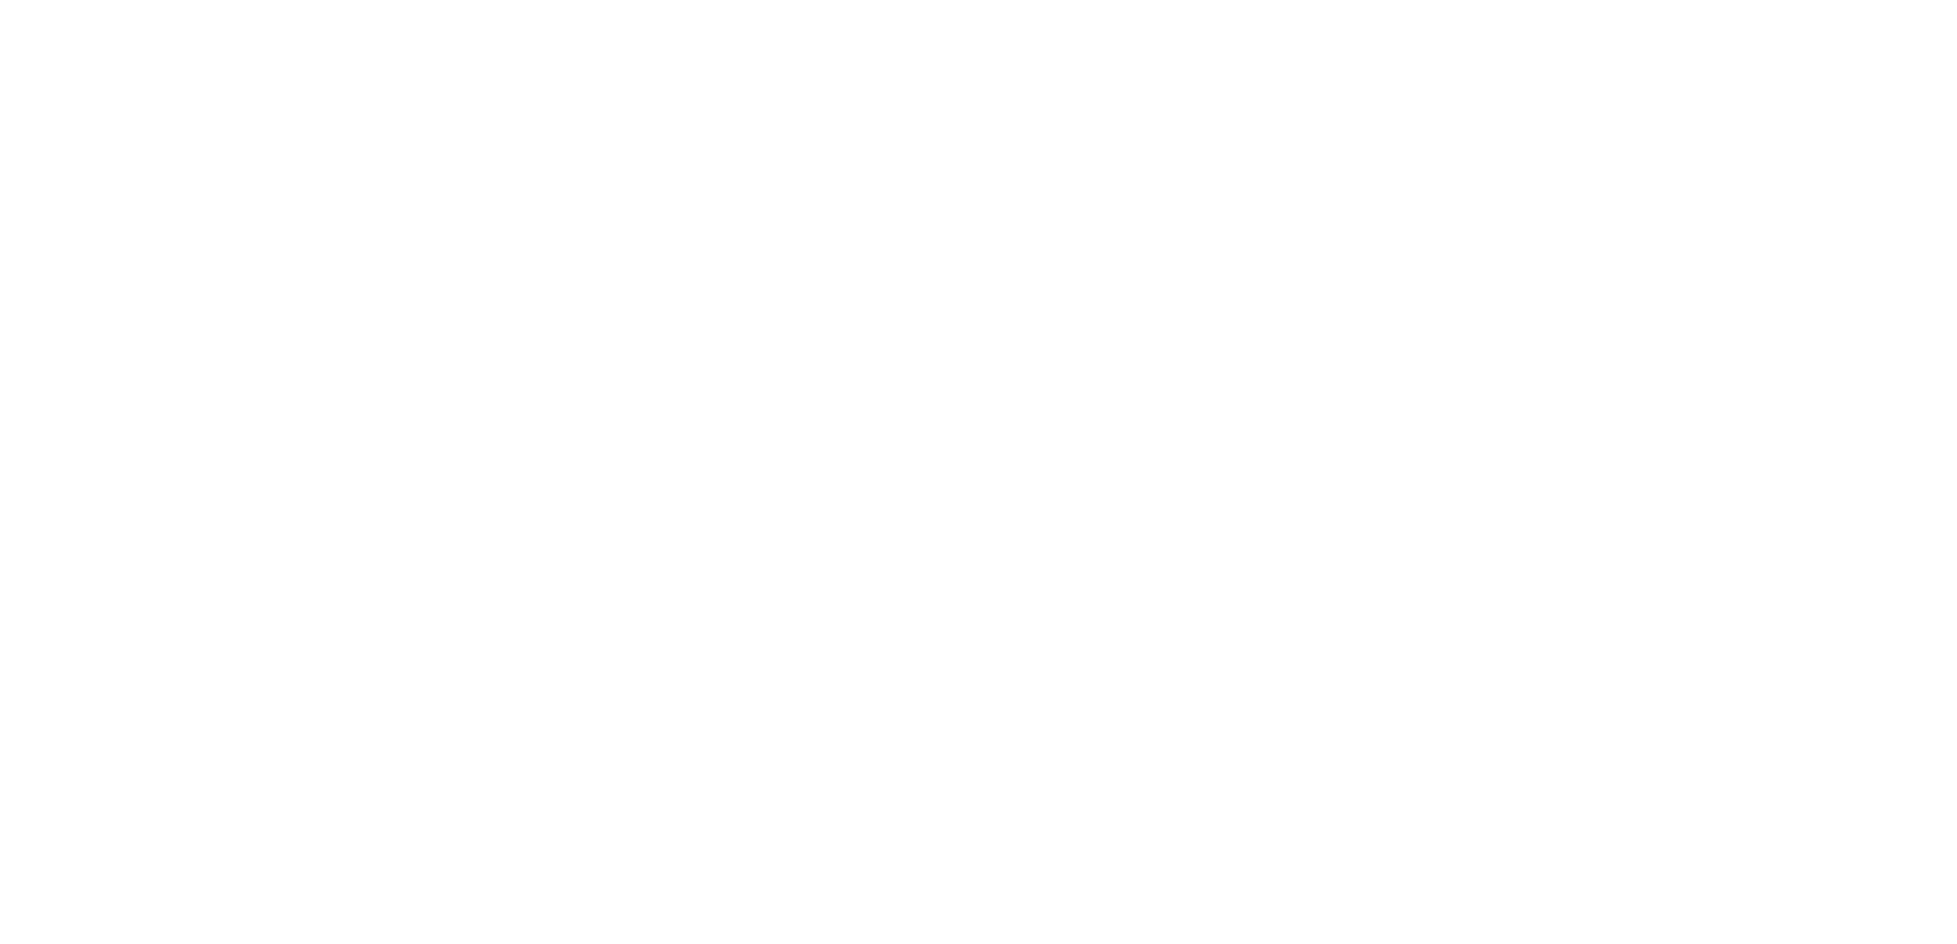

In [18]:
createChordAndmakeChordAnimation([0,1,0,0,0,3],['N','B','G','N','N','E'],'BGE1')

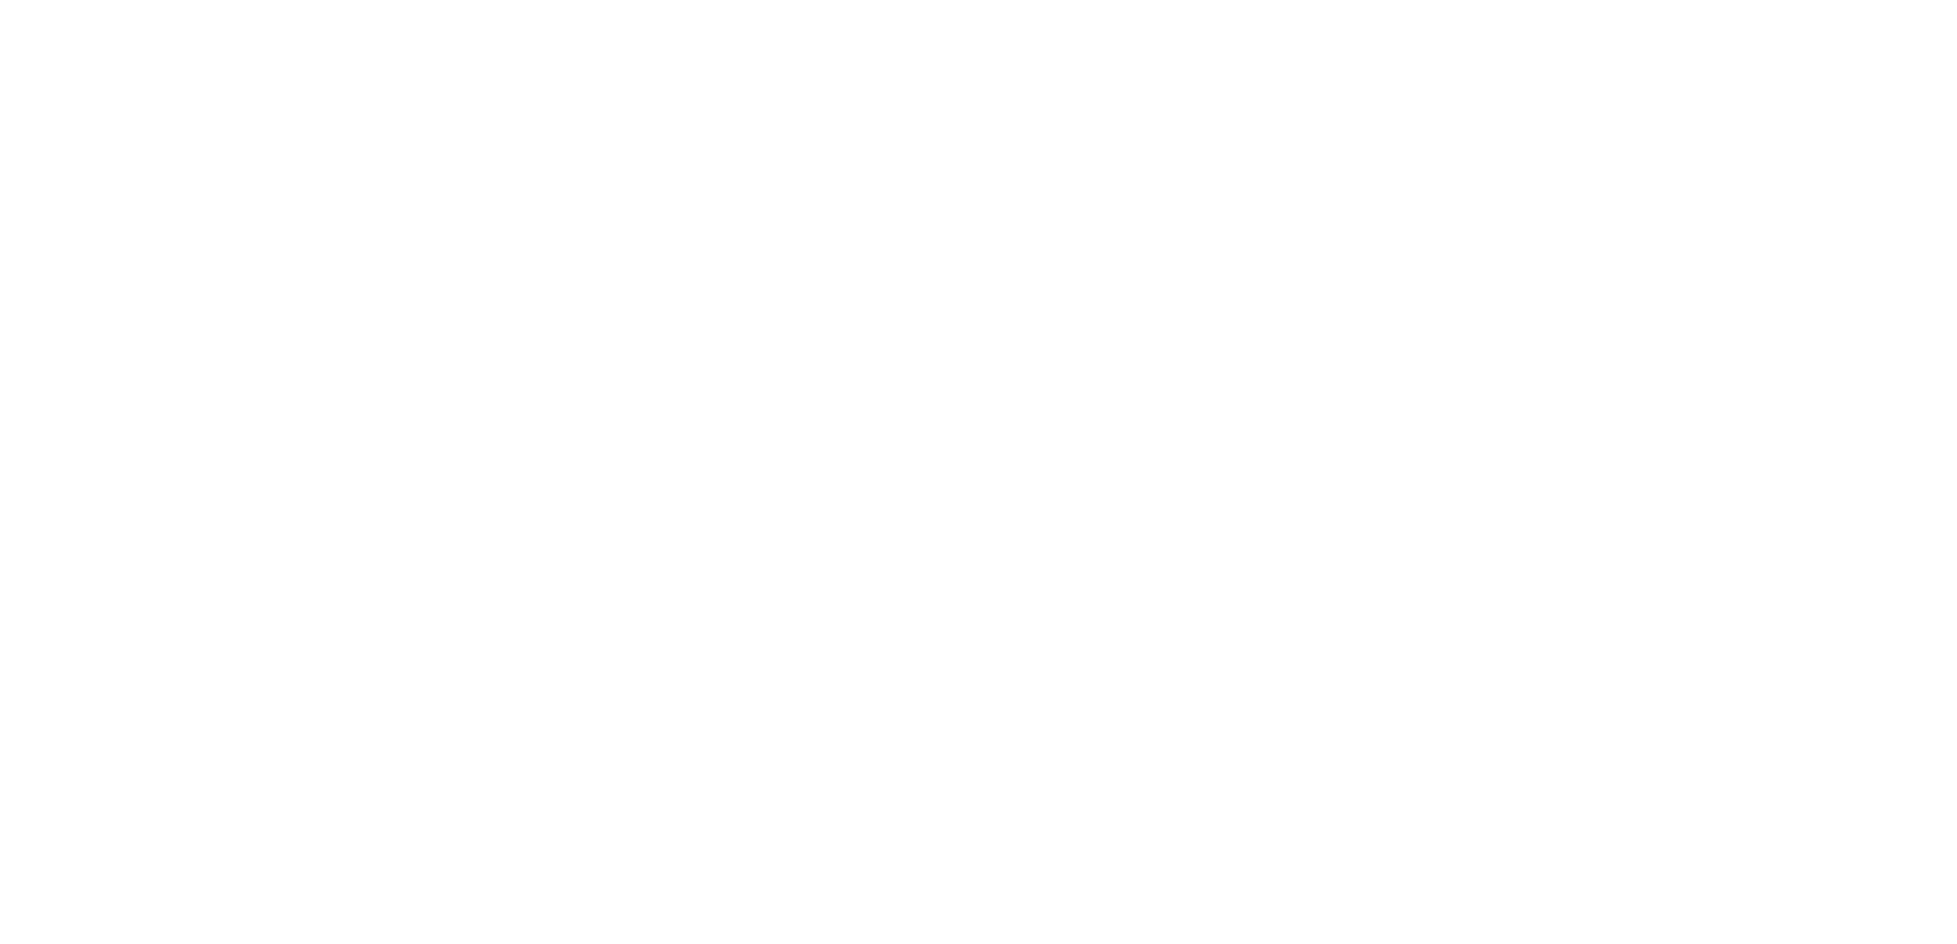

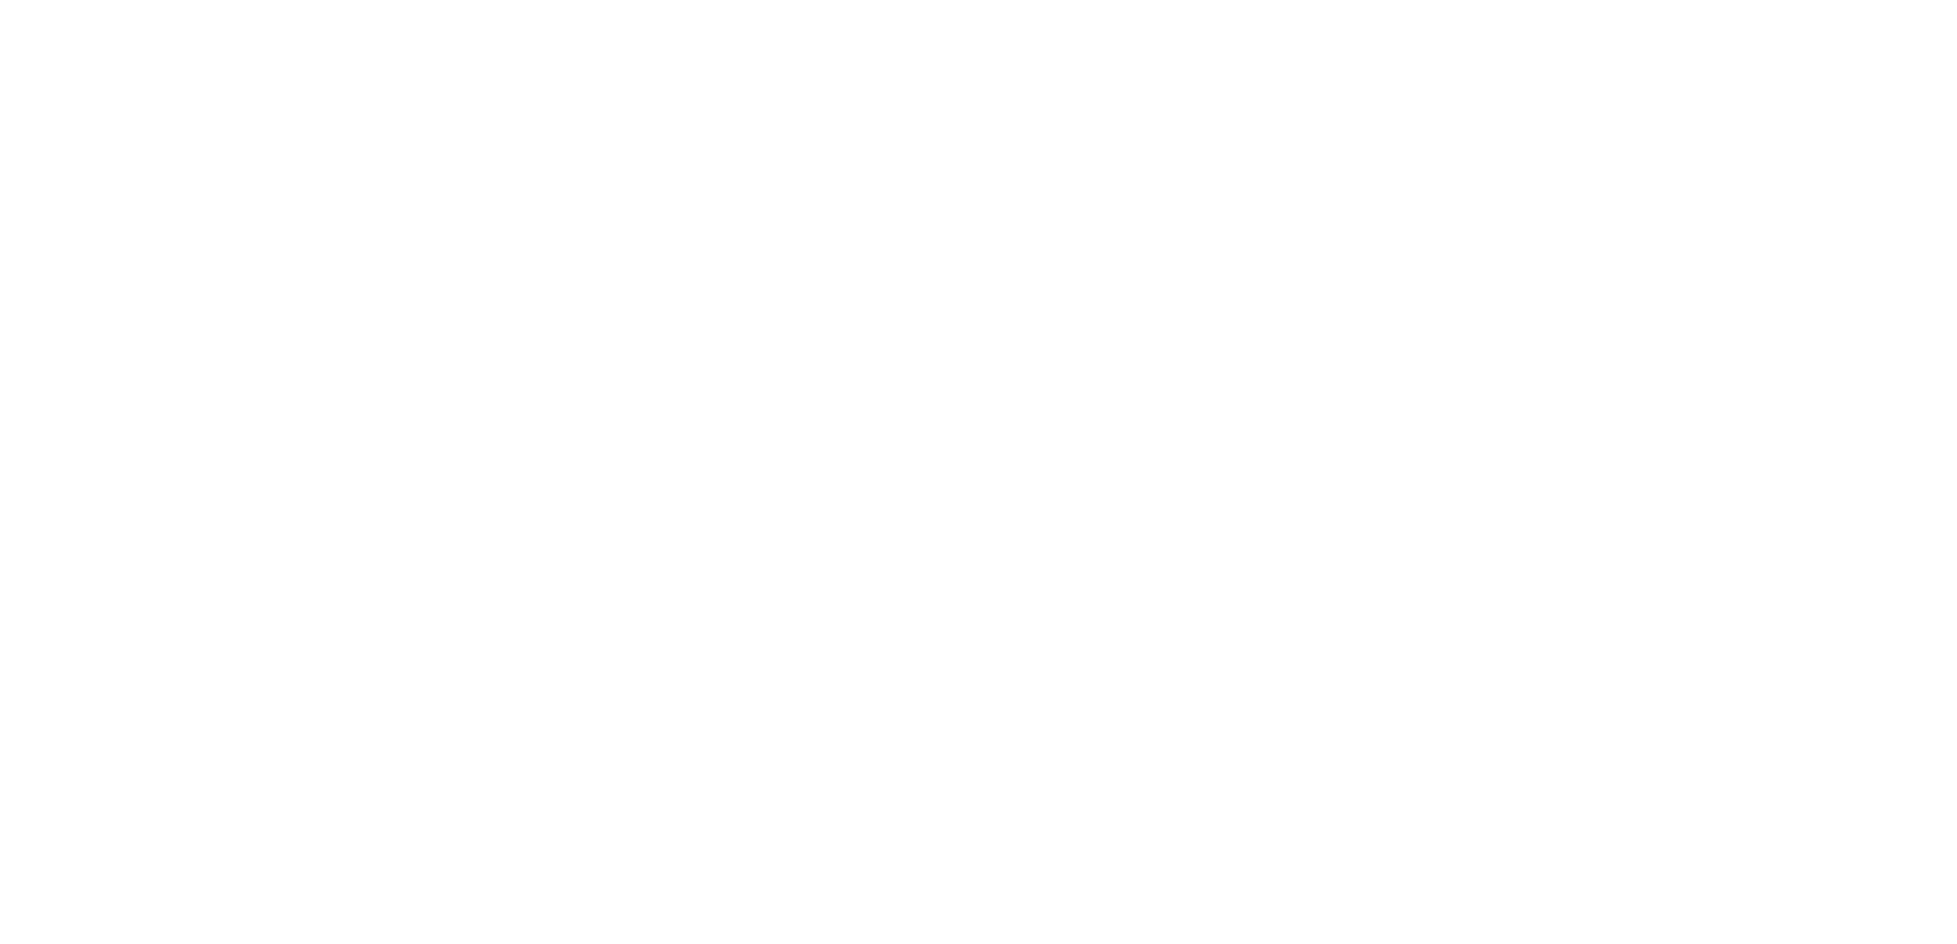

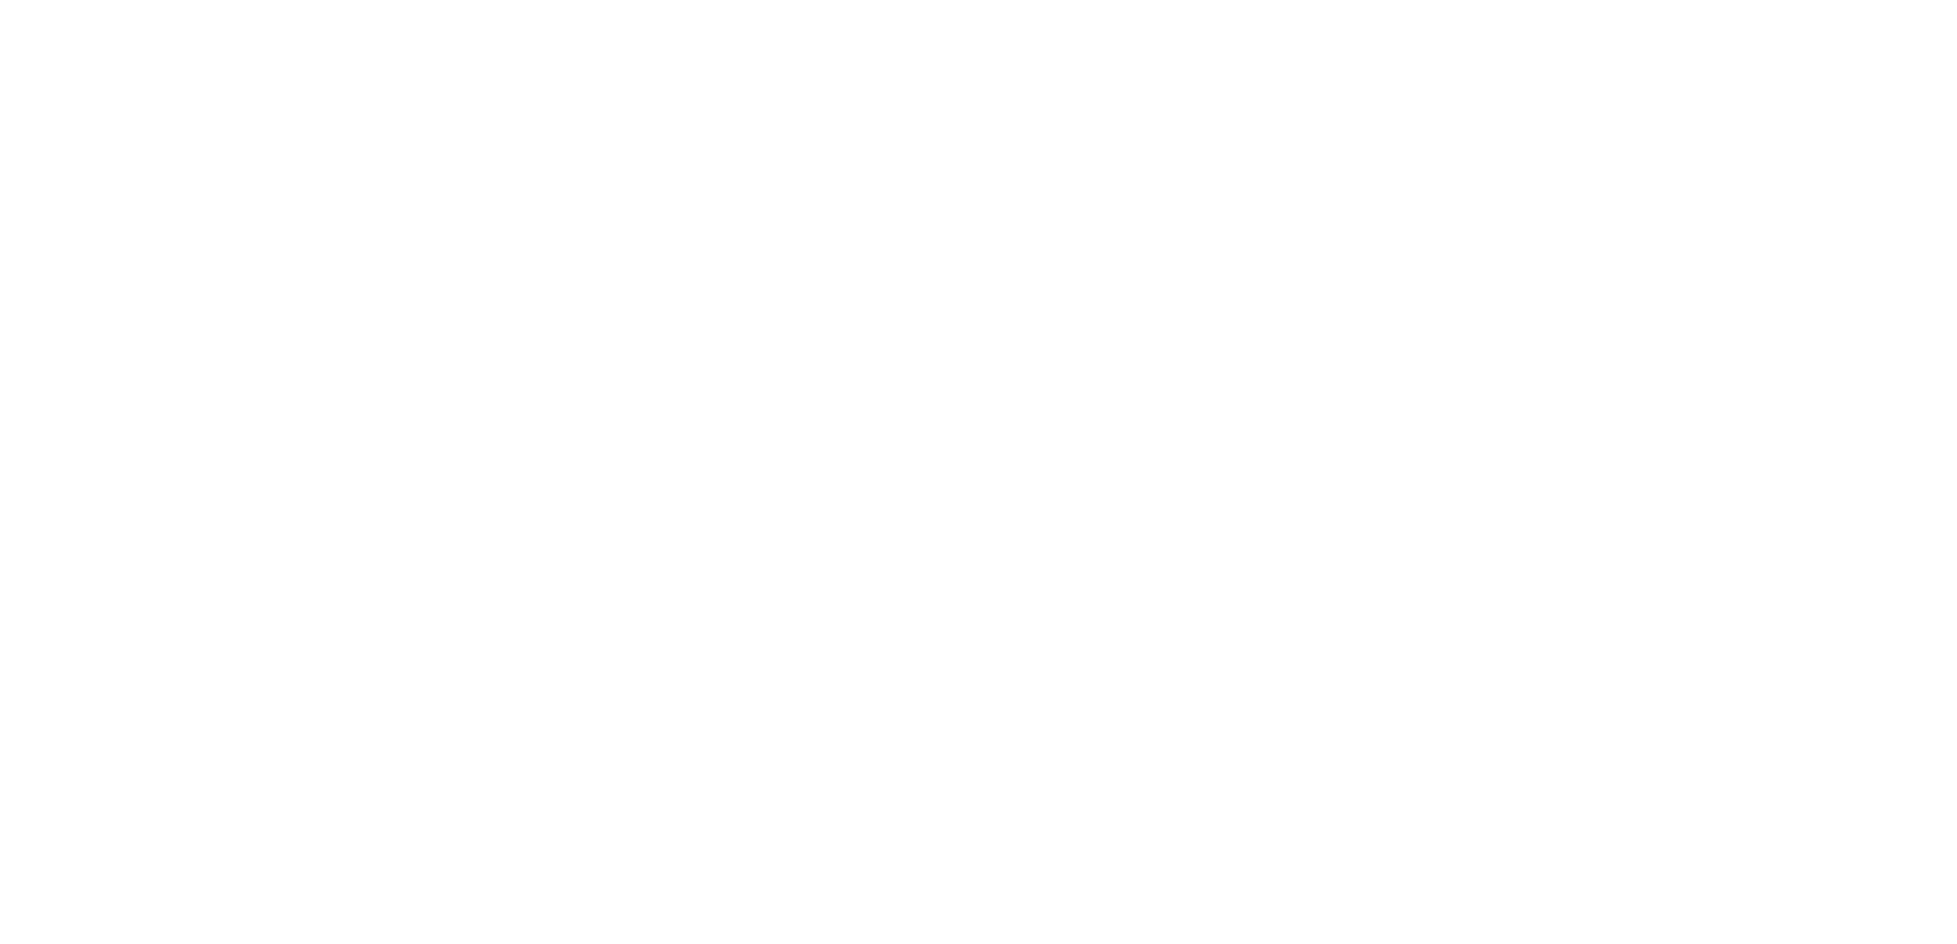

In [17]:
createChordAndmakeChordAnimation([0,0,0,0,0,3],['N','N','G','D','N','E'],'GDE3')
createChordAndmakeChordAnimation([0,0,3,3,0,3],['N','N','G','D','N','E'],'GDE333')
createChordAndmakeChordAnimation([0,1,0,0,0,3],['N','B','G','N','N','E'],'BGE1')

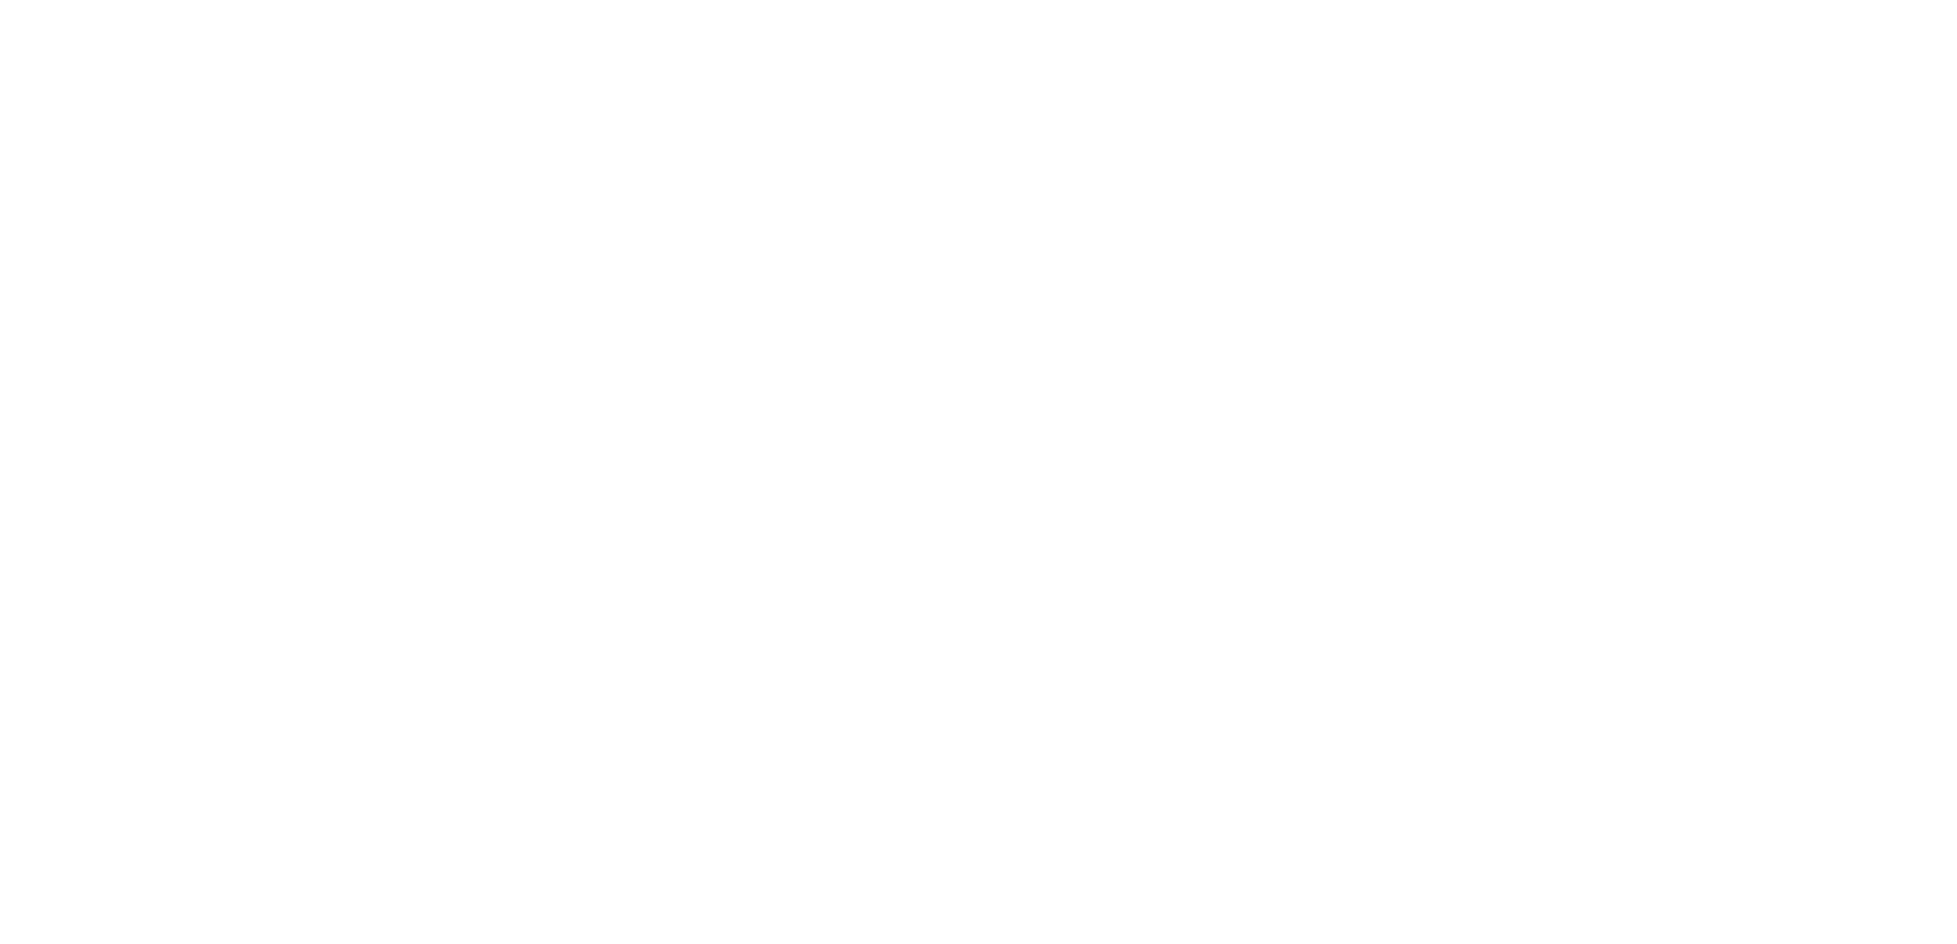

In [19]:
createChordAndmakeChordAnimation([0,2,1,0,0,3],['N','B','G','N','N','E'],'BGE213')

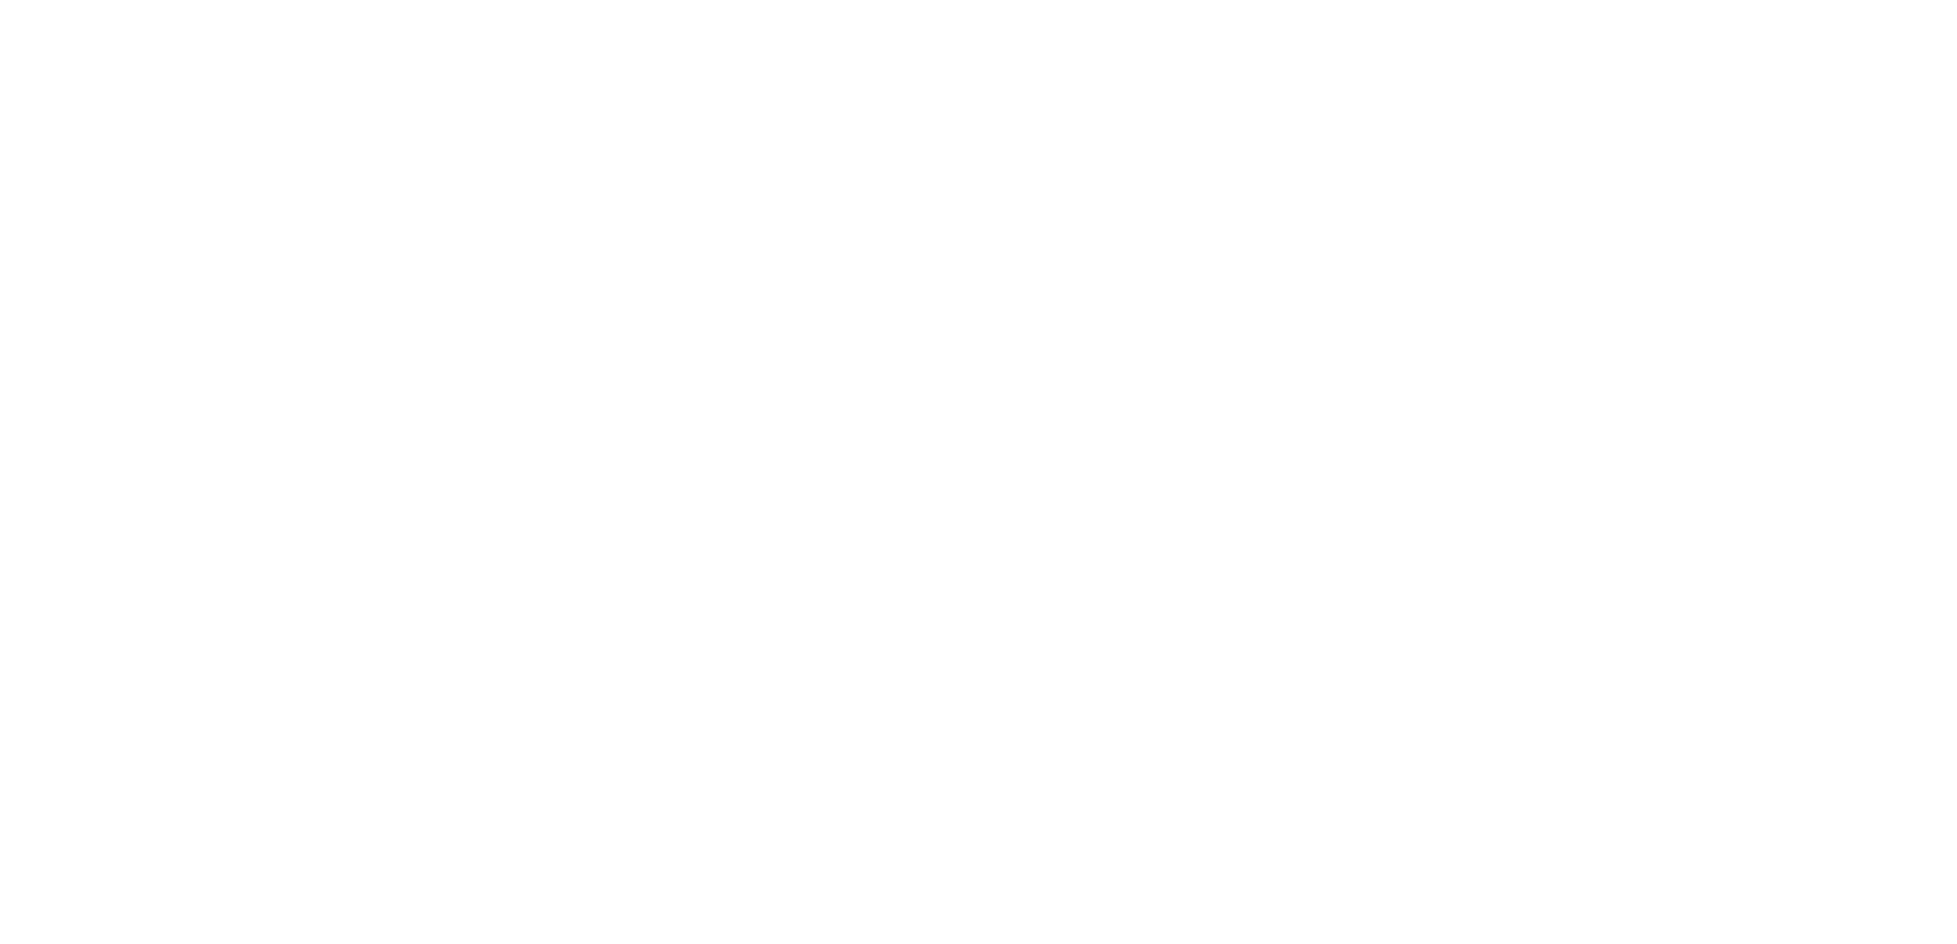

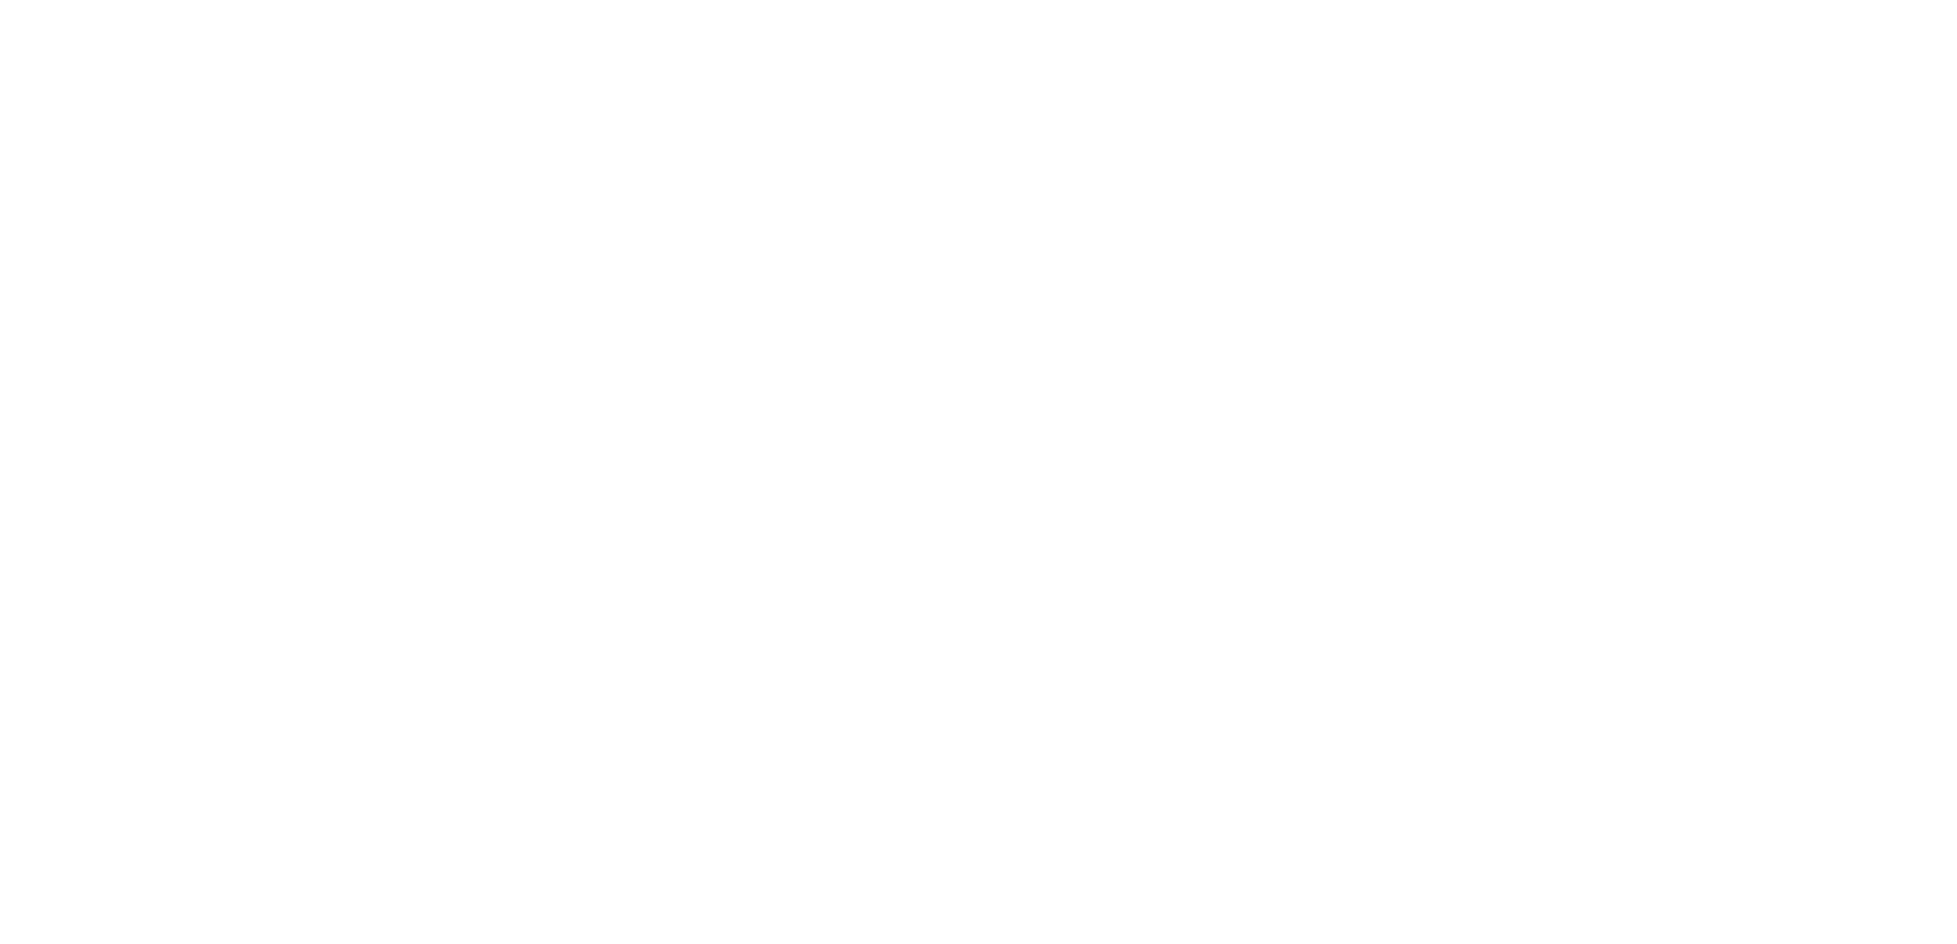

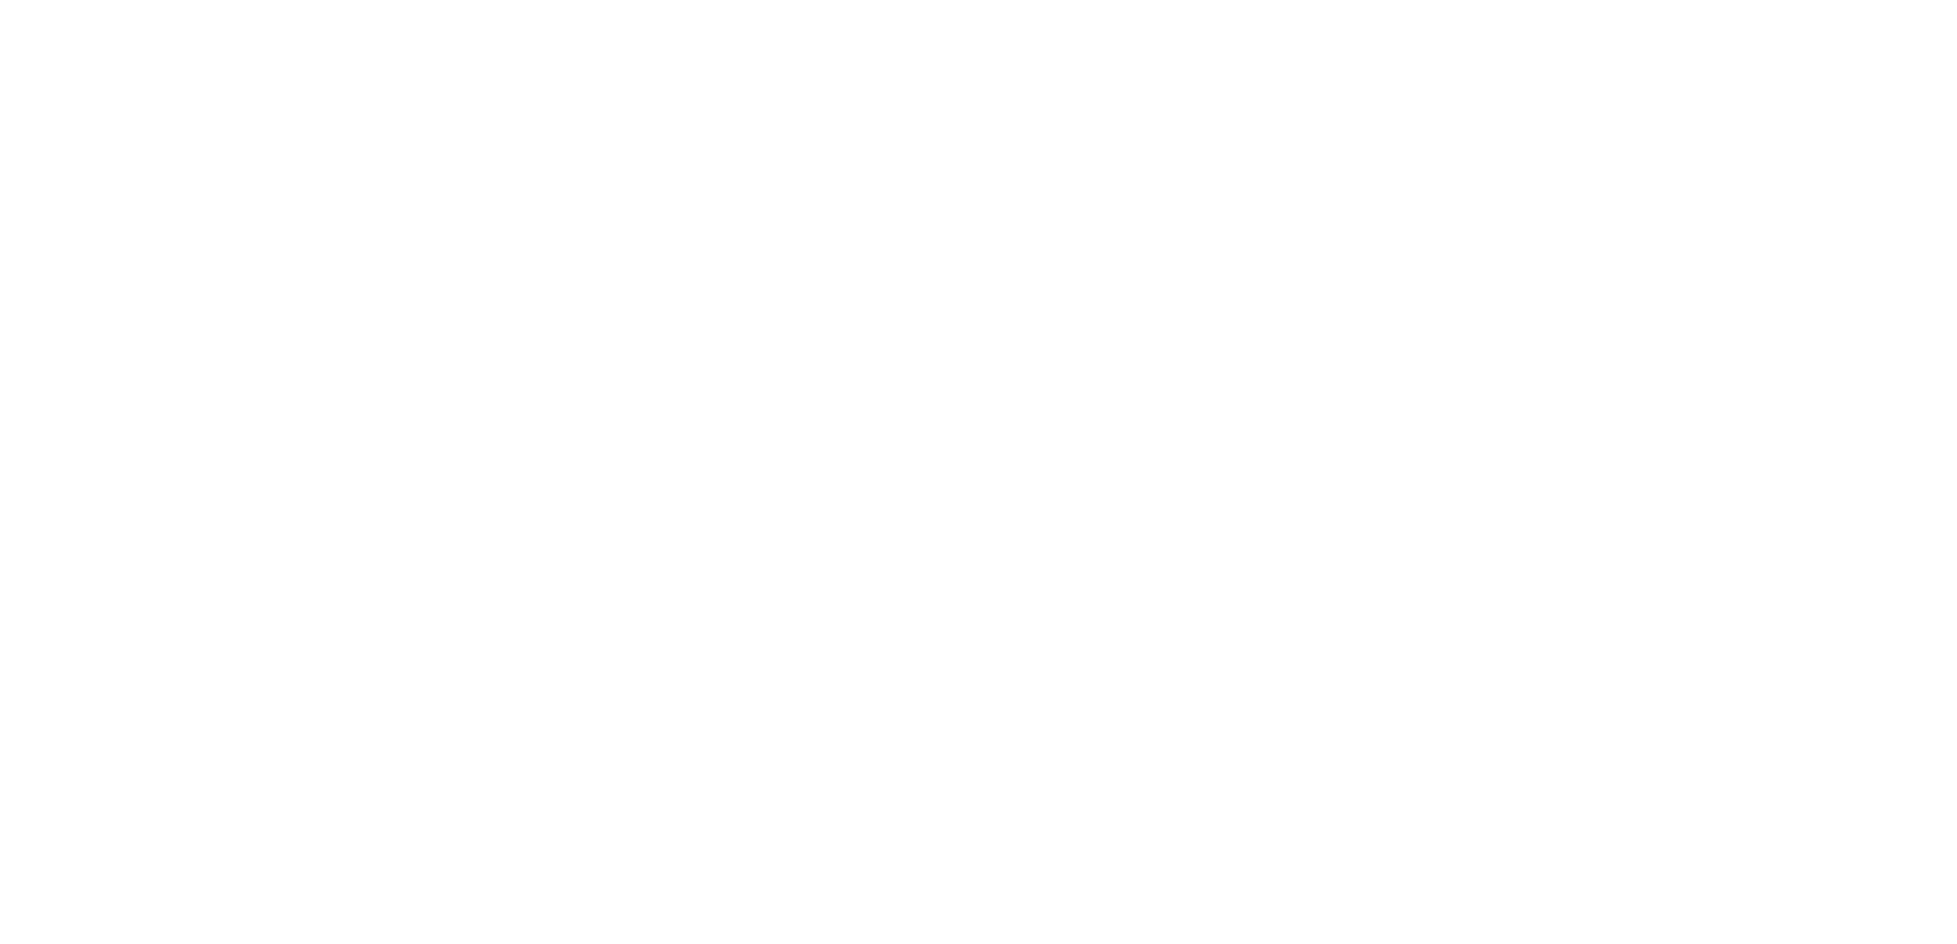

In [20]:
createChordAndmakeChordAnimation([0,0,0,0,3,0],['N','N','N','N','A','N'],'A3')
createChordAndmakeChordAnimation([0,0,3,3,1,0],['N','N','G','D','A','N'],'GDA331')
createChordAndmakeChordAnimation([0,0,0,0,1,0],['N','N','N','N','A','N'],'A1')


Across the universe

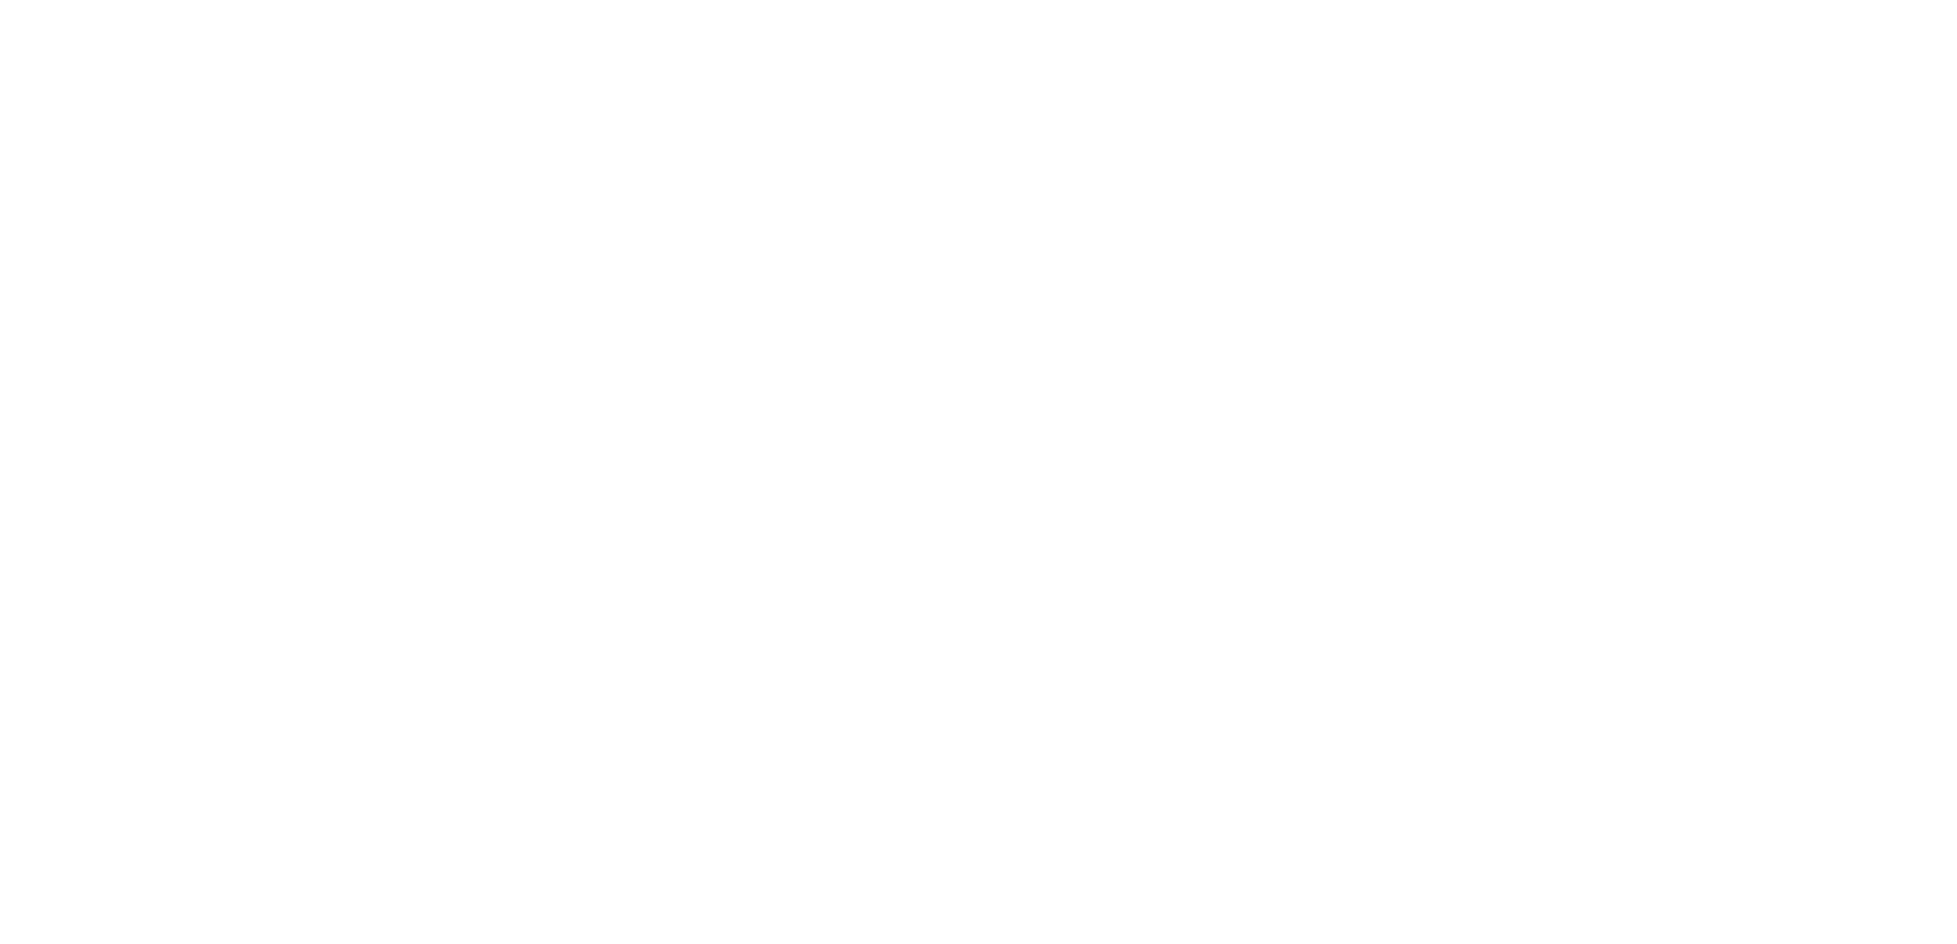

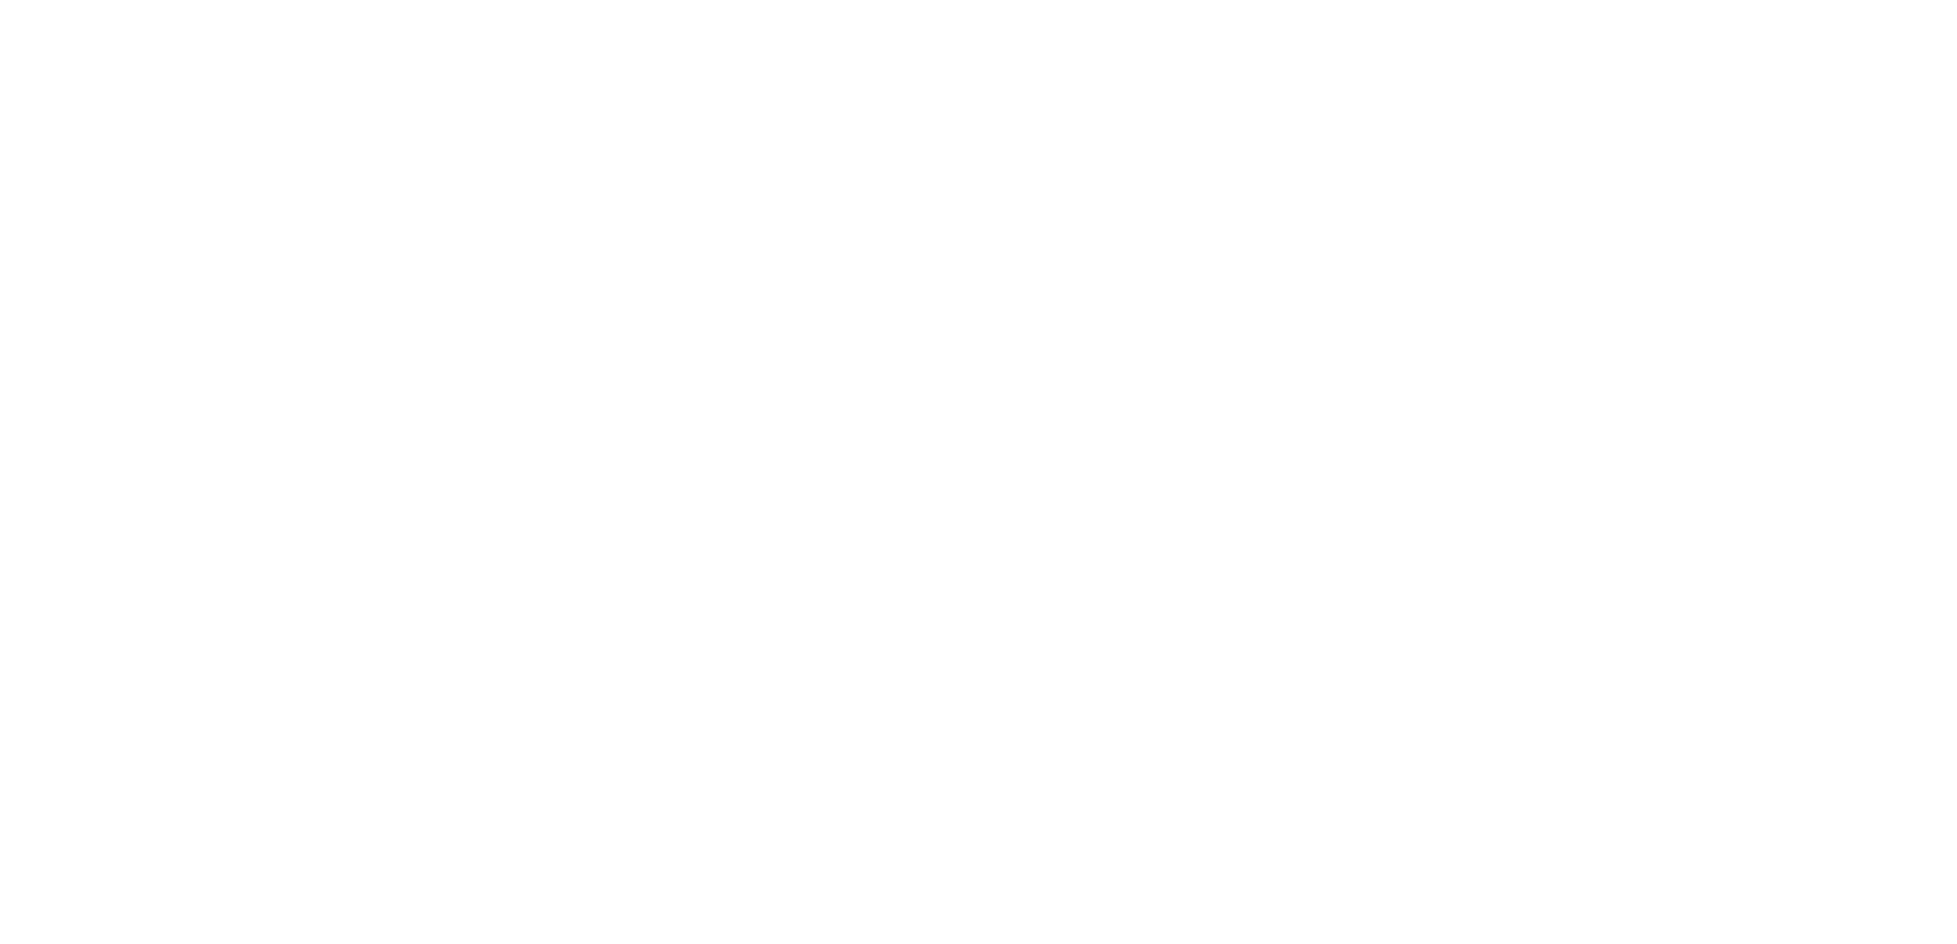

In [3]:
createChordAndmakeChordAnimation([0,2,2,4,4,2],['N','B','G','D','A','E'],'Fm#1')
createChordAndmakeChordAnimation([0,2,4,4,4,2],['N','B','G','D','A','E'],'Fm#2')


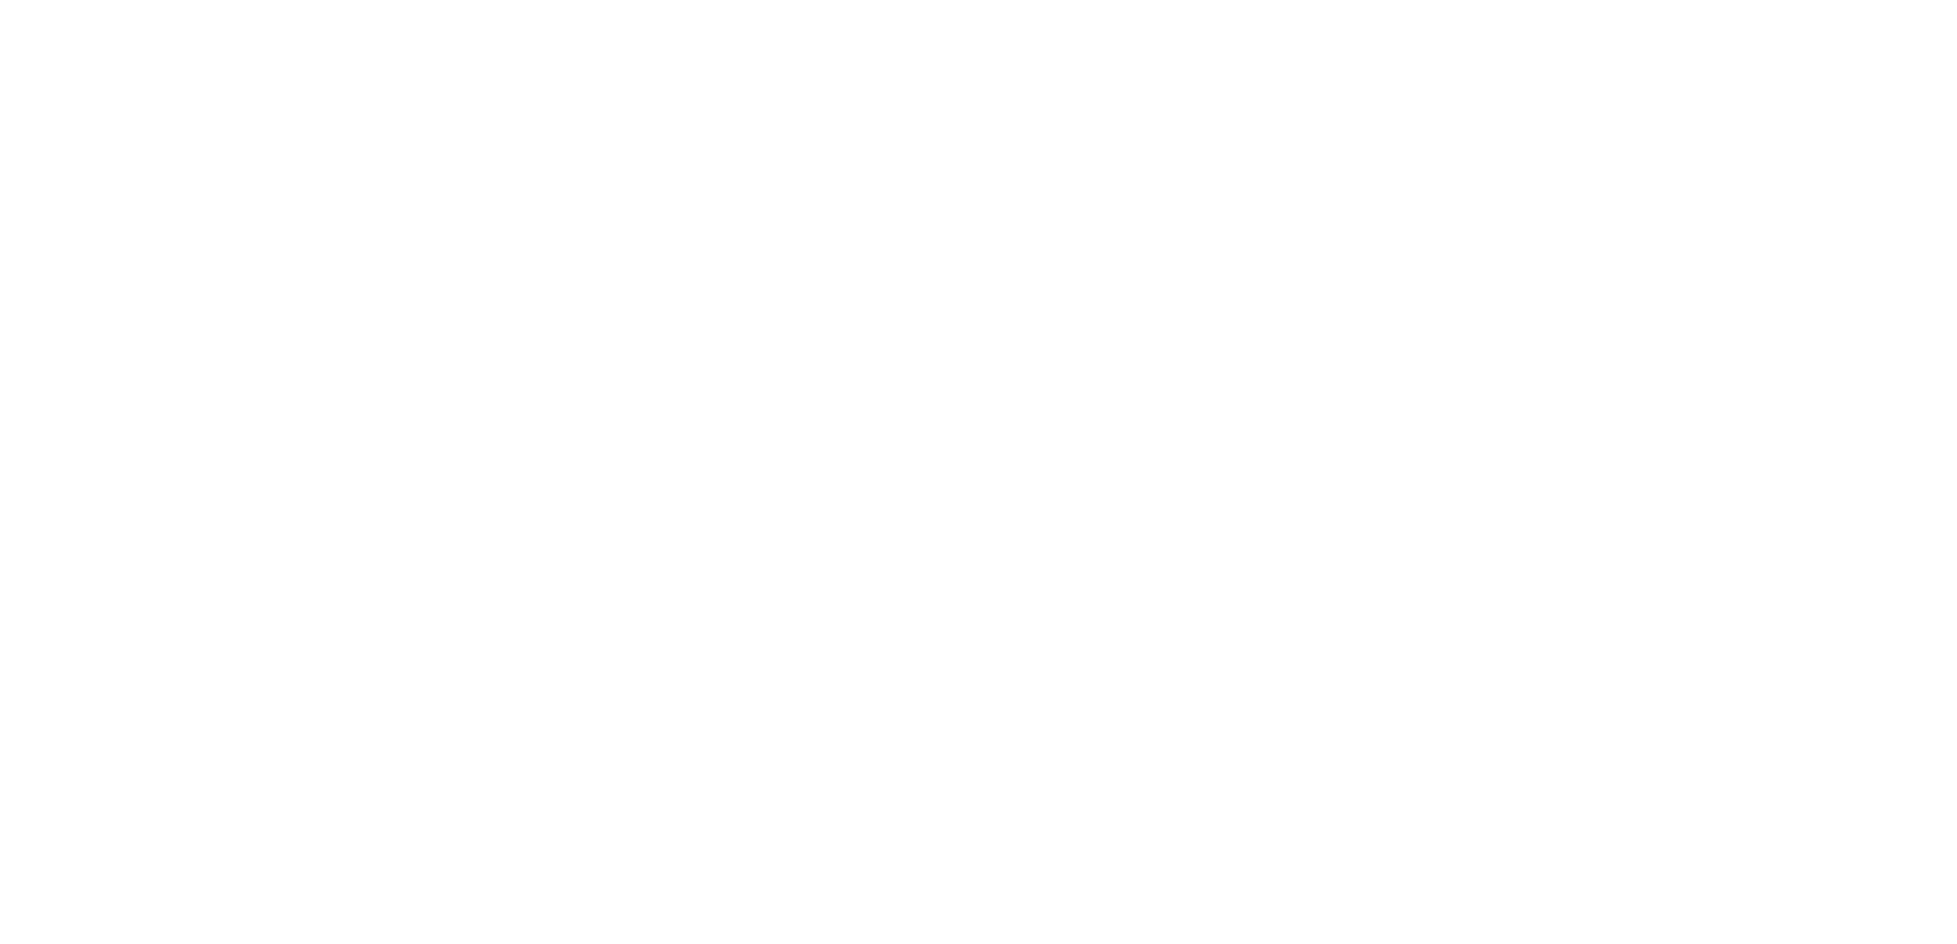

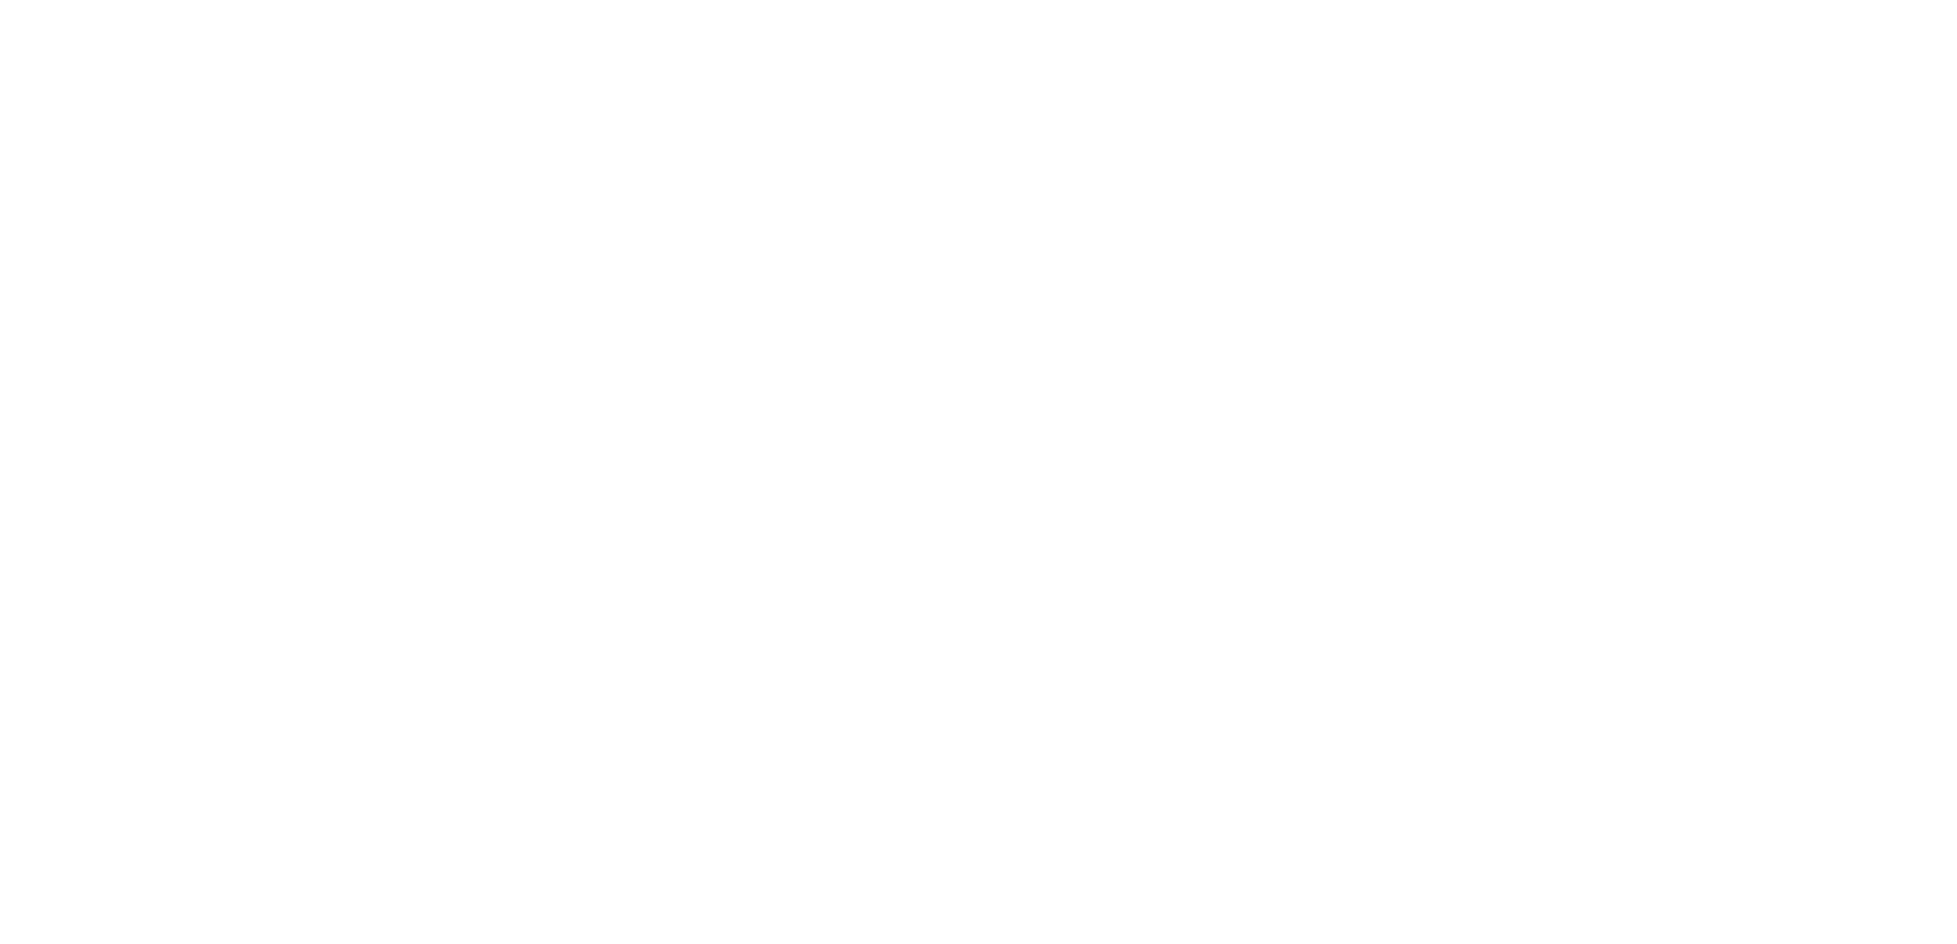

In [4]:
createChordAndmakeChordAnimation([0,2,2,2,0,0],['N','B','G','D','A','N'],'A1')
createChordAndmakeChordAnimation([0,2,4,2,0,0],['N','B','G','D','A','N'],'A2')

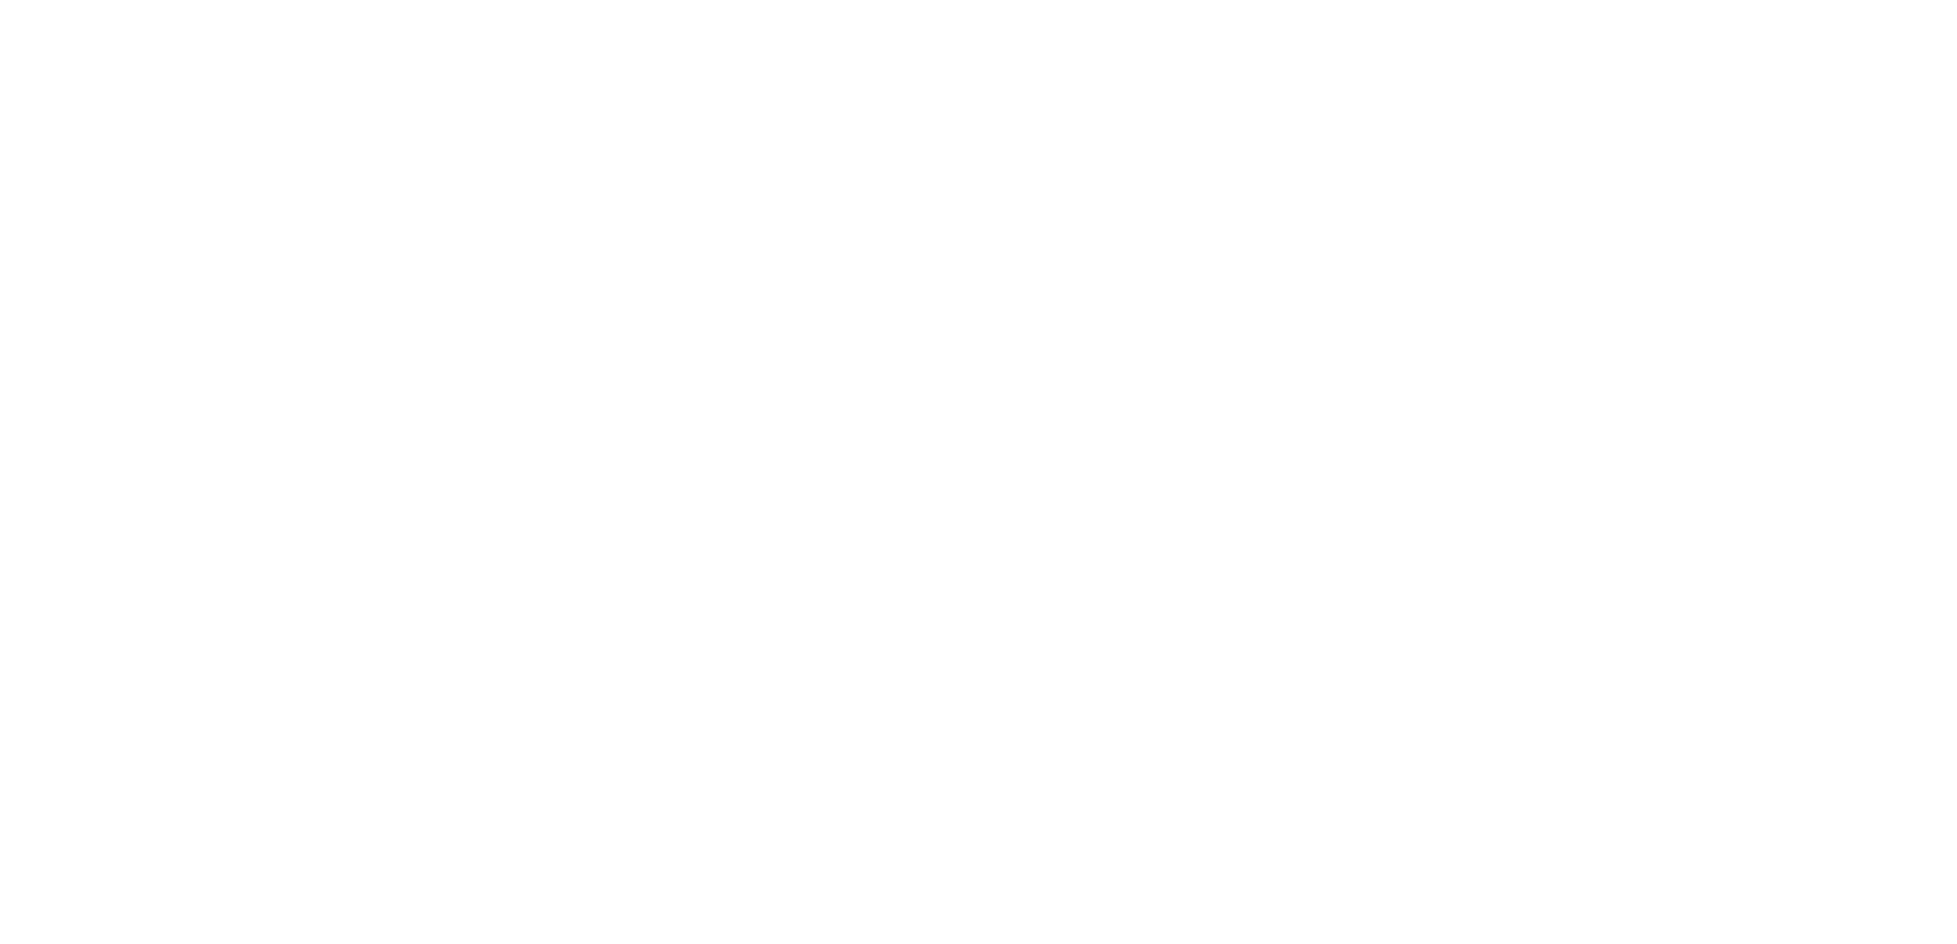

In [8]:
createChordAndmakeChordAnimation([2,3,2,0,0,0],['e','B','G','D','N','N'],'D')


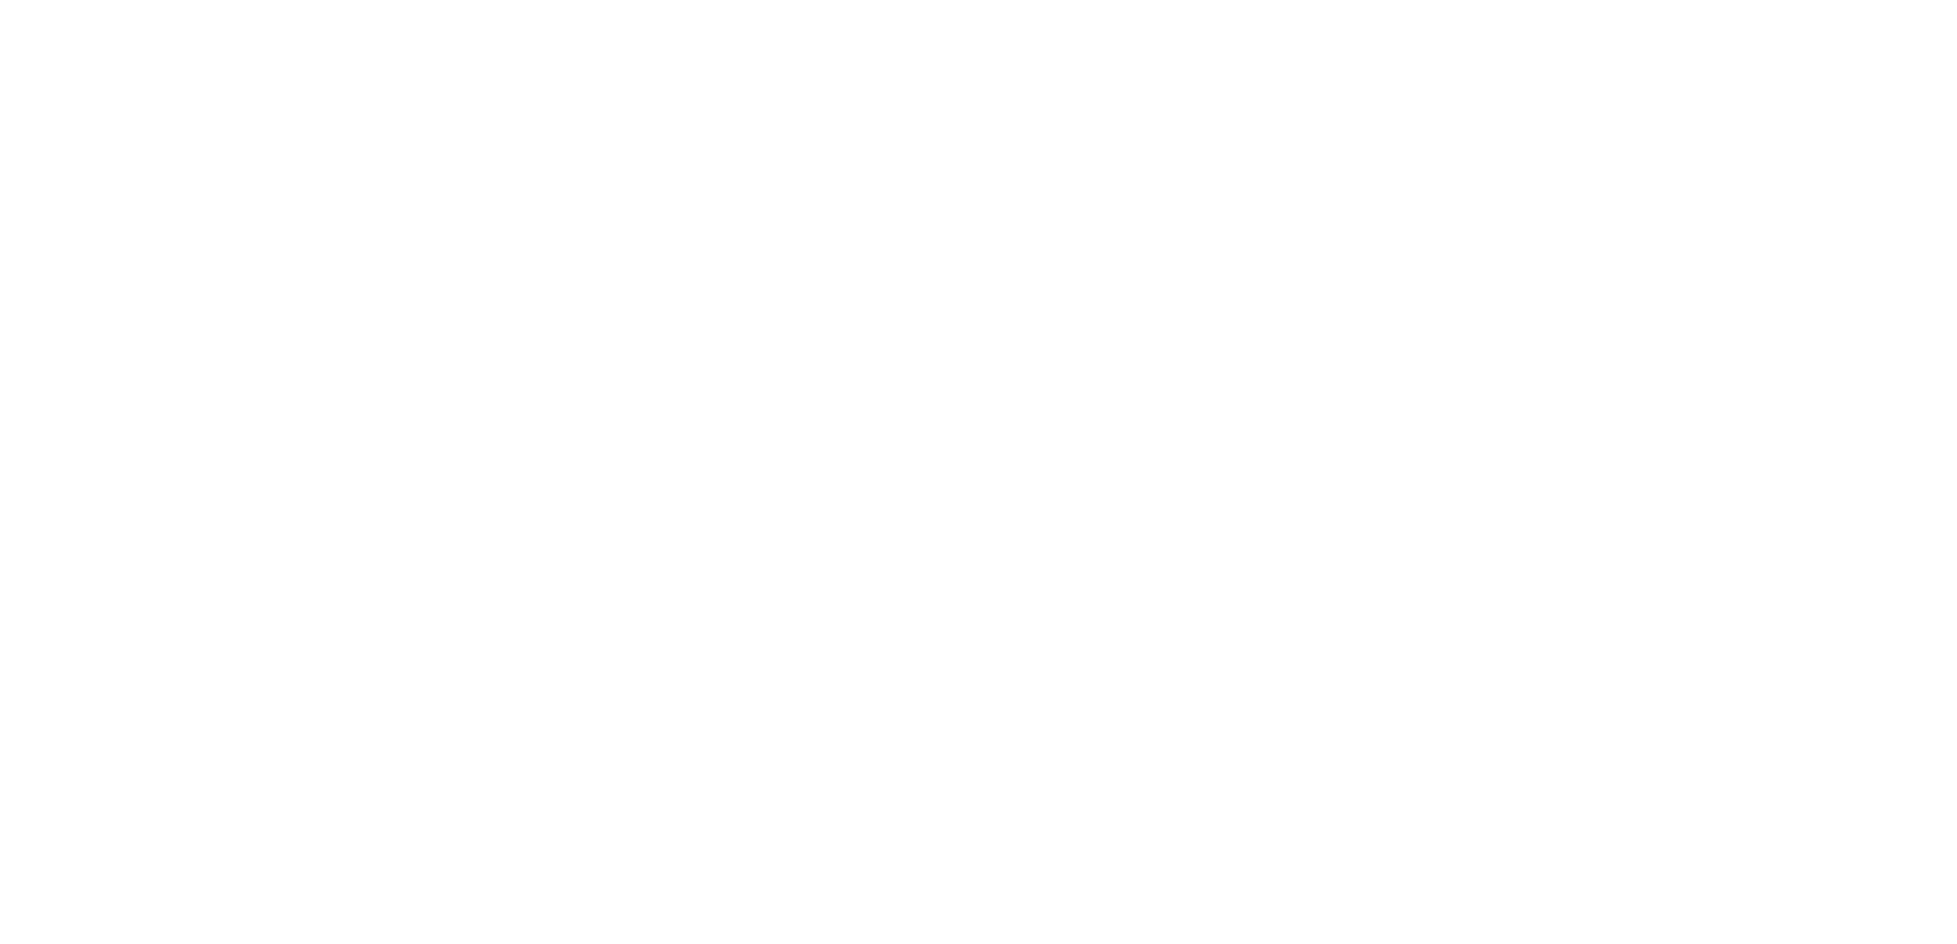

In [9]:
createChordAndmakeChordAnimation([2,3,4,4,1,0],['e','B','G','D','A','N'],'Bm')


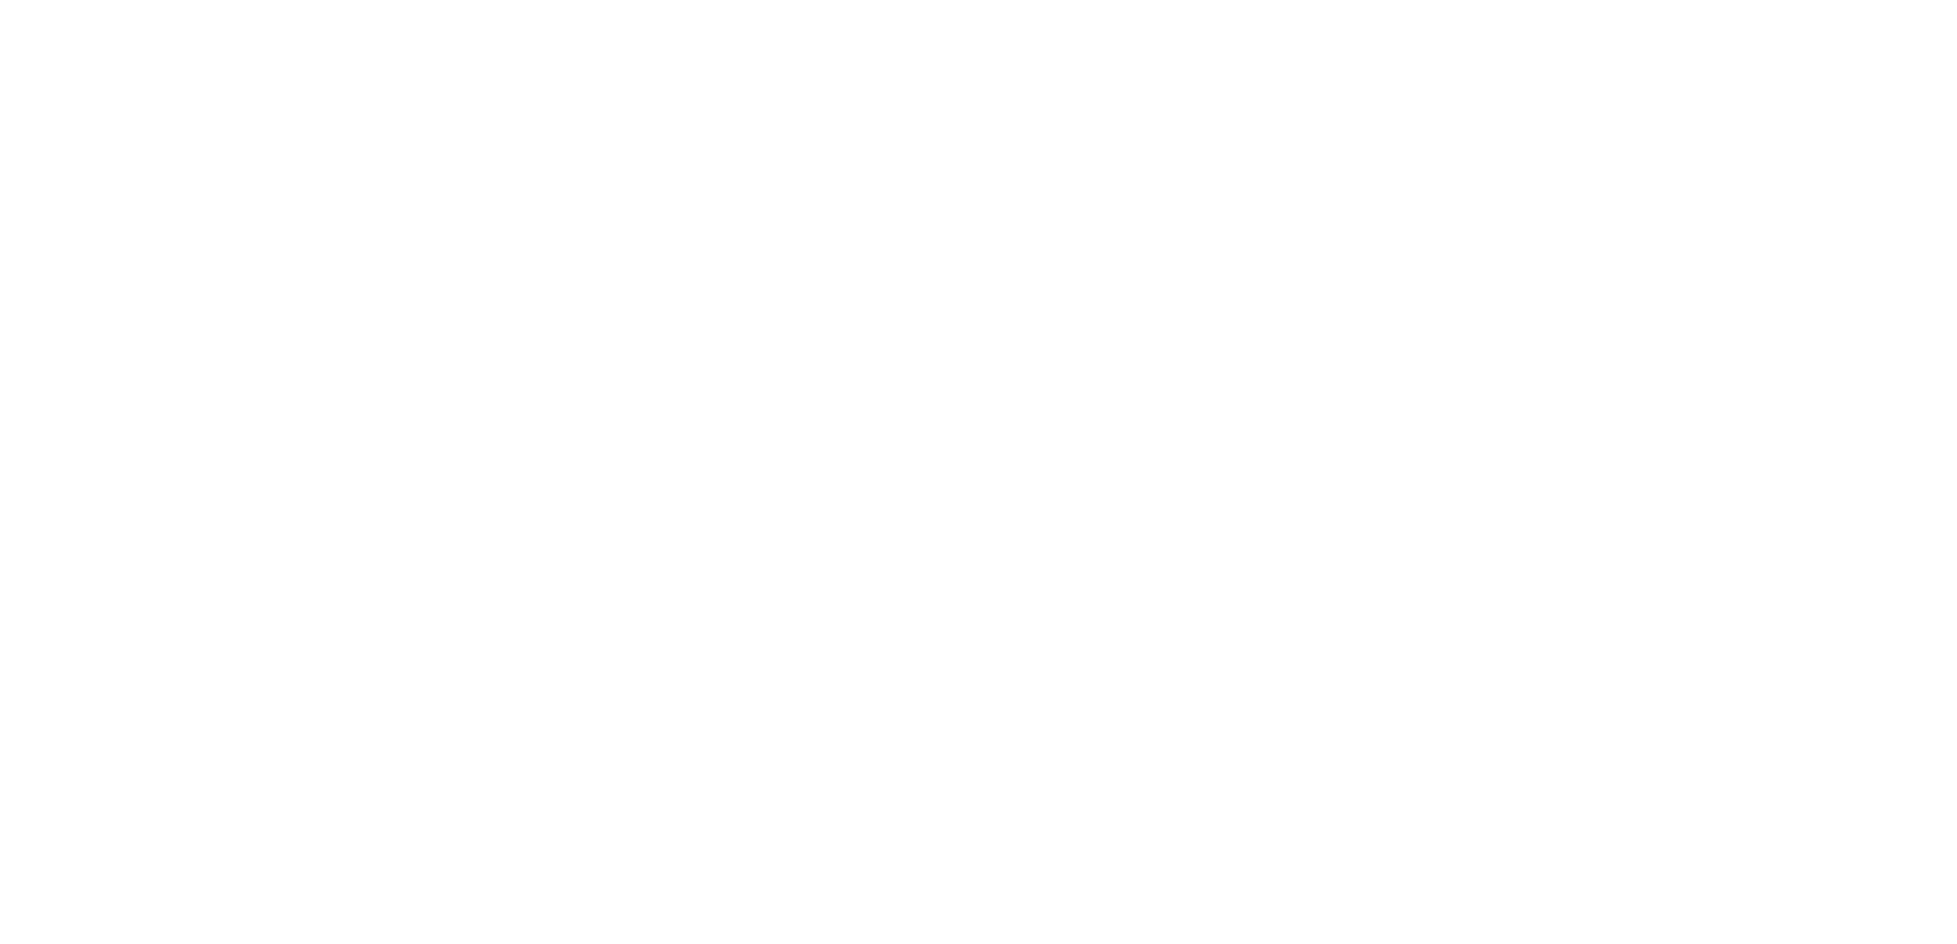

In [10]:
createChordAndmakeChordAnimation([2,2,2,4,4,2],['e','B','G','D','A','E'],'F#m')


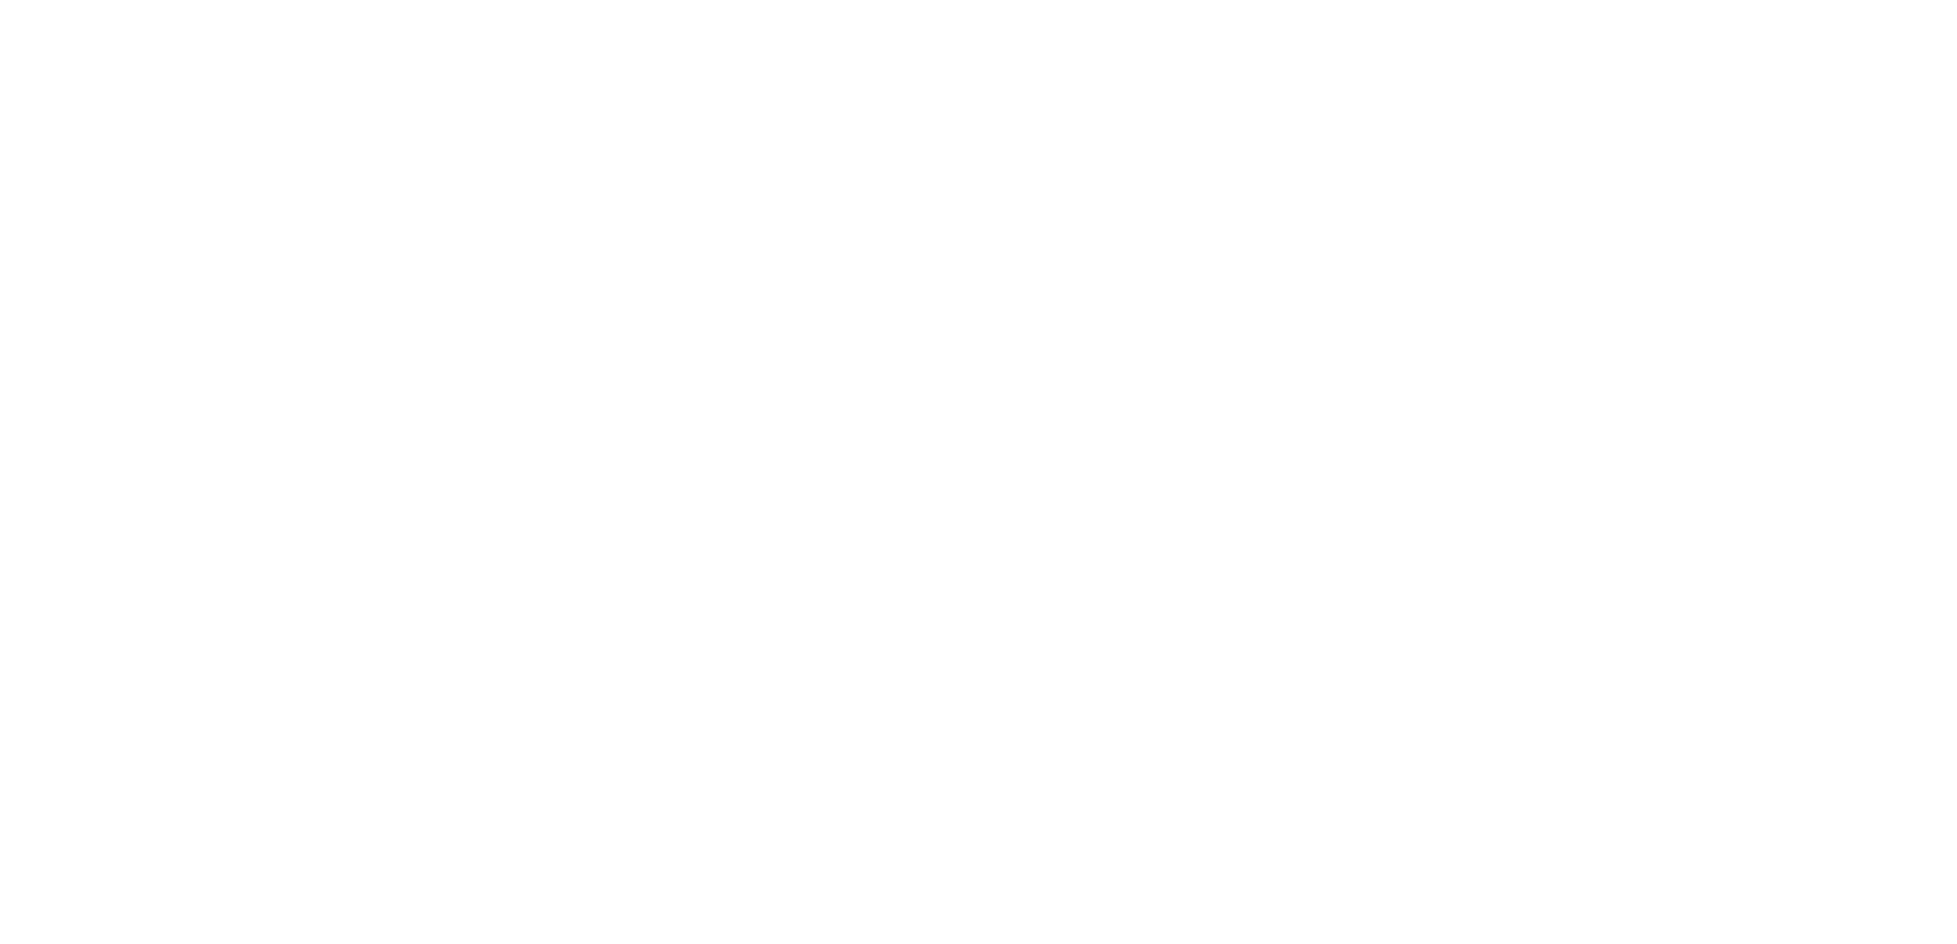

In [11]:
createChordAndmakeChordAnimation([0,3,0,2,2,0],['e','B','G','D','A','E'],'Em7')


In [ ]:
note, solution = createNote(12, 'B')
playNote(note)

In [ ]:
createNoteAndMakeAnimation(0, 'B')
createNoteAndMakeAnimation(0, 'G')
createNoteAndMakeAnimation(0, 'A')
createNoteAndMakeAnimation(1, 'B')
createNoteAndMakeAnimation(3, 'B')
createNoteAndMakeAnimation(2, 'A')
createNoteAndMakeAnimation(3, 'E')

In [ ]:
createNoteAndMakeAnimation(12, 'B')
createNoteAndMakeAnimation(10, 'A')
createNoteAndMakeAnimation(0, 'G')

In [ ]:
tempo = 95 / 60 # beats per second
beat = 1 / tempo
samplingRate = 20000
beatLength = int(beat*samplingRate)

def quaver(notes):
    quaverBeatLength = int(beatLength/2)
    silence = np.zeros(quaverBeatLength)
    firstNote = notes[0]
    secondNote = np.concatenate((silence, notes[1]))
    tot = np.zeros(beatLength)
    tot += firstNote[:beatLength]
    tot += secondNote[:beatLength]
    
    return tot.astype(np.float32)

def triplet(notes):
    tripletBeatLength = int(beatLength/3)
    silence = np.zeros(tripletBeatLength)
    firstNote = notes[0]
    secondNote = np.concatenate((silence, notes[1]))
    thirdNote = np.concatenate((silence, silence, notes[2]))

    tot = np.zeros(beatLength)
    tot += firstNote[:beatLength]
    tot += secondNote[:beatLength]
    tot += thirdNote[:beatLength]

    return tot.astype(np.float32)

In [ ]:
A10, _ = createNote(10, 'A')
B12, _ = createNote(12, 'B')
G0, _= createNote(0, 'G')

G2 = triplet([A10 + B12, G0, B12])
wavfile.write('G2.wav',samplingRate,G2.astype(np.float32))
Audio('G2.wav')

In [ ]:
playNote(np.concatenate((A10, np.zeros(5000))) + np.concatenate((np.zeros(5000), G0)))

In [ ]:
E3, _ = createNote(3, 'E')
G0, _ = createNote(0, 'G')
B0, _ = createNote(0, 'B')
G1 = quaver([E3 + B0, G0])
wavfile.write('G1.wav',samplingRate,G1)
Audio('G1.wav')

In [ ]:
A0, _ = createNote(0, 'A')
B1, _ = createNote(1, 'B')
Am7 = quaver([B1 + A0, G0])
wavfile.write('Am7.wav',samplingRate,Am7)
Audio('Am7.wav')

In [ ]:
B3, _ = createNote(3, 'B')
A2, _ = createNote(2, 'A')
GB = quaver([B3 + A2, G0])
wavfile.write('GB.wav',samplingRate,GB)
Audio('GB.wav')